Dear Reader, please note that this notebook was written in Jupyter Notebook and as such some features (particularly graphs) may not work on kaggle - I have marked the respective parts and generally recommend downloading and opening in Jupyter Notebook to be able to follow my thoughts behind some graphs 

In [1]:
import warnings
warnings.filterwarnings("ignore") #can get annoying and visually distracting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import seaborn as sns

import pyLDAvis
import pyLDAvis.gensim #for kaggle
#import pyLDAvis.gensim_models #for Jupyter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim import corpora
import en_core_web_sm
import re
import spacy

from wordcloud import WordCloud

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behav

In [2]:
#Loading data directly in kaggle
df = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/train.csv")
test = pd.read_csv("../input/us-patent-phrase-to-phrase-matching/test.csv")

print(f"train data shape: {df.shape}; test data shape: {test.shape}")
#notably, the test data very short and contains no output feature

train data shape: (36473, 5); test data shape: (36, 4)


Breakdown of features:
1. ID: unique identifier  - won't be used
2. anchor: first phrase
3. target: second phrase
4. context: CPC Classification Number - scoring similarity within these groups (https://en.wikipedia.org/wiki/Cooperative_Patent_Classification)
5. score: similarity score = outcome variable
      * 1.0 = very close; 0.75 = close; 0.5 synonyms with different meaning; 0.25 = somewhat related; 0.0 = unrelated
     

# Goal:
predict the score as value of similarity between anchor and target within each context


-> While we want to score the similarity between anchor and target, the context can heavily impact this similarity! 

In result, all columns of the data set (except ID) need to be explored

# Preprocessing

In [3]:
df.head()

id     anchor                  target context  score
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75
2  36d72442aefd8232  abatement         active catalyst     A47   0.25
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00

In [4]:
#Are all IDs unique identifiers? (because you never know)
len(np.unique(df.id)), df.shape[0]
#the length of unique values matches the train shape; there are no duplicates in the dataset

(36473, 36473)

<AxesSubplot:>

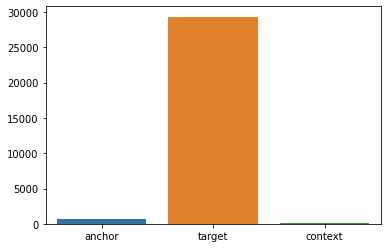

In [5]:
#unique values per feature (not including ID)
vals = [len(np.unique(df.anchor)), len(np.unique(df.target)), len(np.unique(df.context))]
sns.barplot(x = ["anchor", "target", "context"], y = vals)
#notably, although anchor and target are heavily related by meaning, the unique values vary greatly. 
#However, ~7000 target values seem to be identical, given that there are 36473 unique entries in the df.

## Feature: Anchor

In [6]:
df.anchor.value_counts(), df.anchor.value_counts().reset_index().describe()

(component composite coating              152
 sheet supply roller                      150
 source voltage                           140
 perfluoroalkyl group                     136
 el display                               135
                                         ... 
 plug nozzle                                2
 shannon                                    2
 dry coating composition1                   2
 peripheral nervous system stimulation      1
 conduct conducting material                1
 Name: anchor, Length: 733, dtype: int64,
            anchor
 count  733.000000
 mean    49.758527
 std     25.204580
 min      1.000000
 25%     27.000000
 50%     47.000000
 75%     66.000000
 max    152.000000)

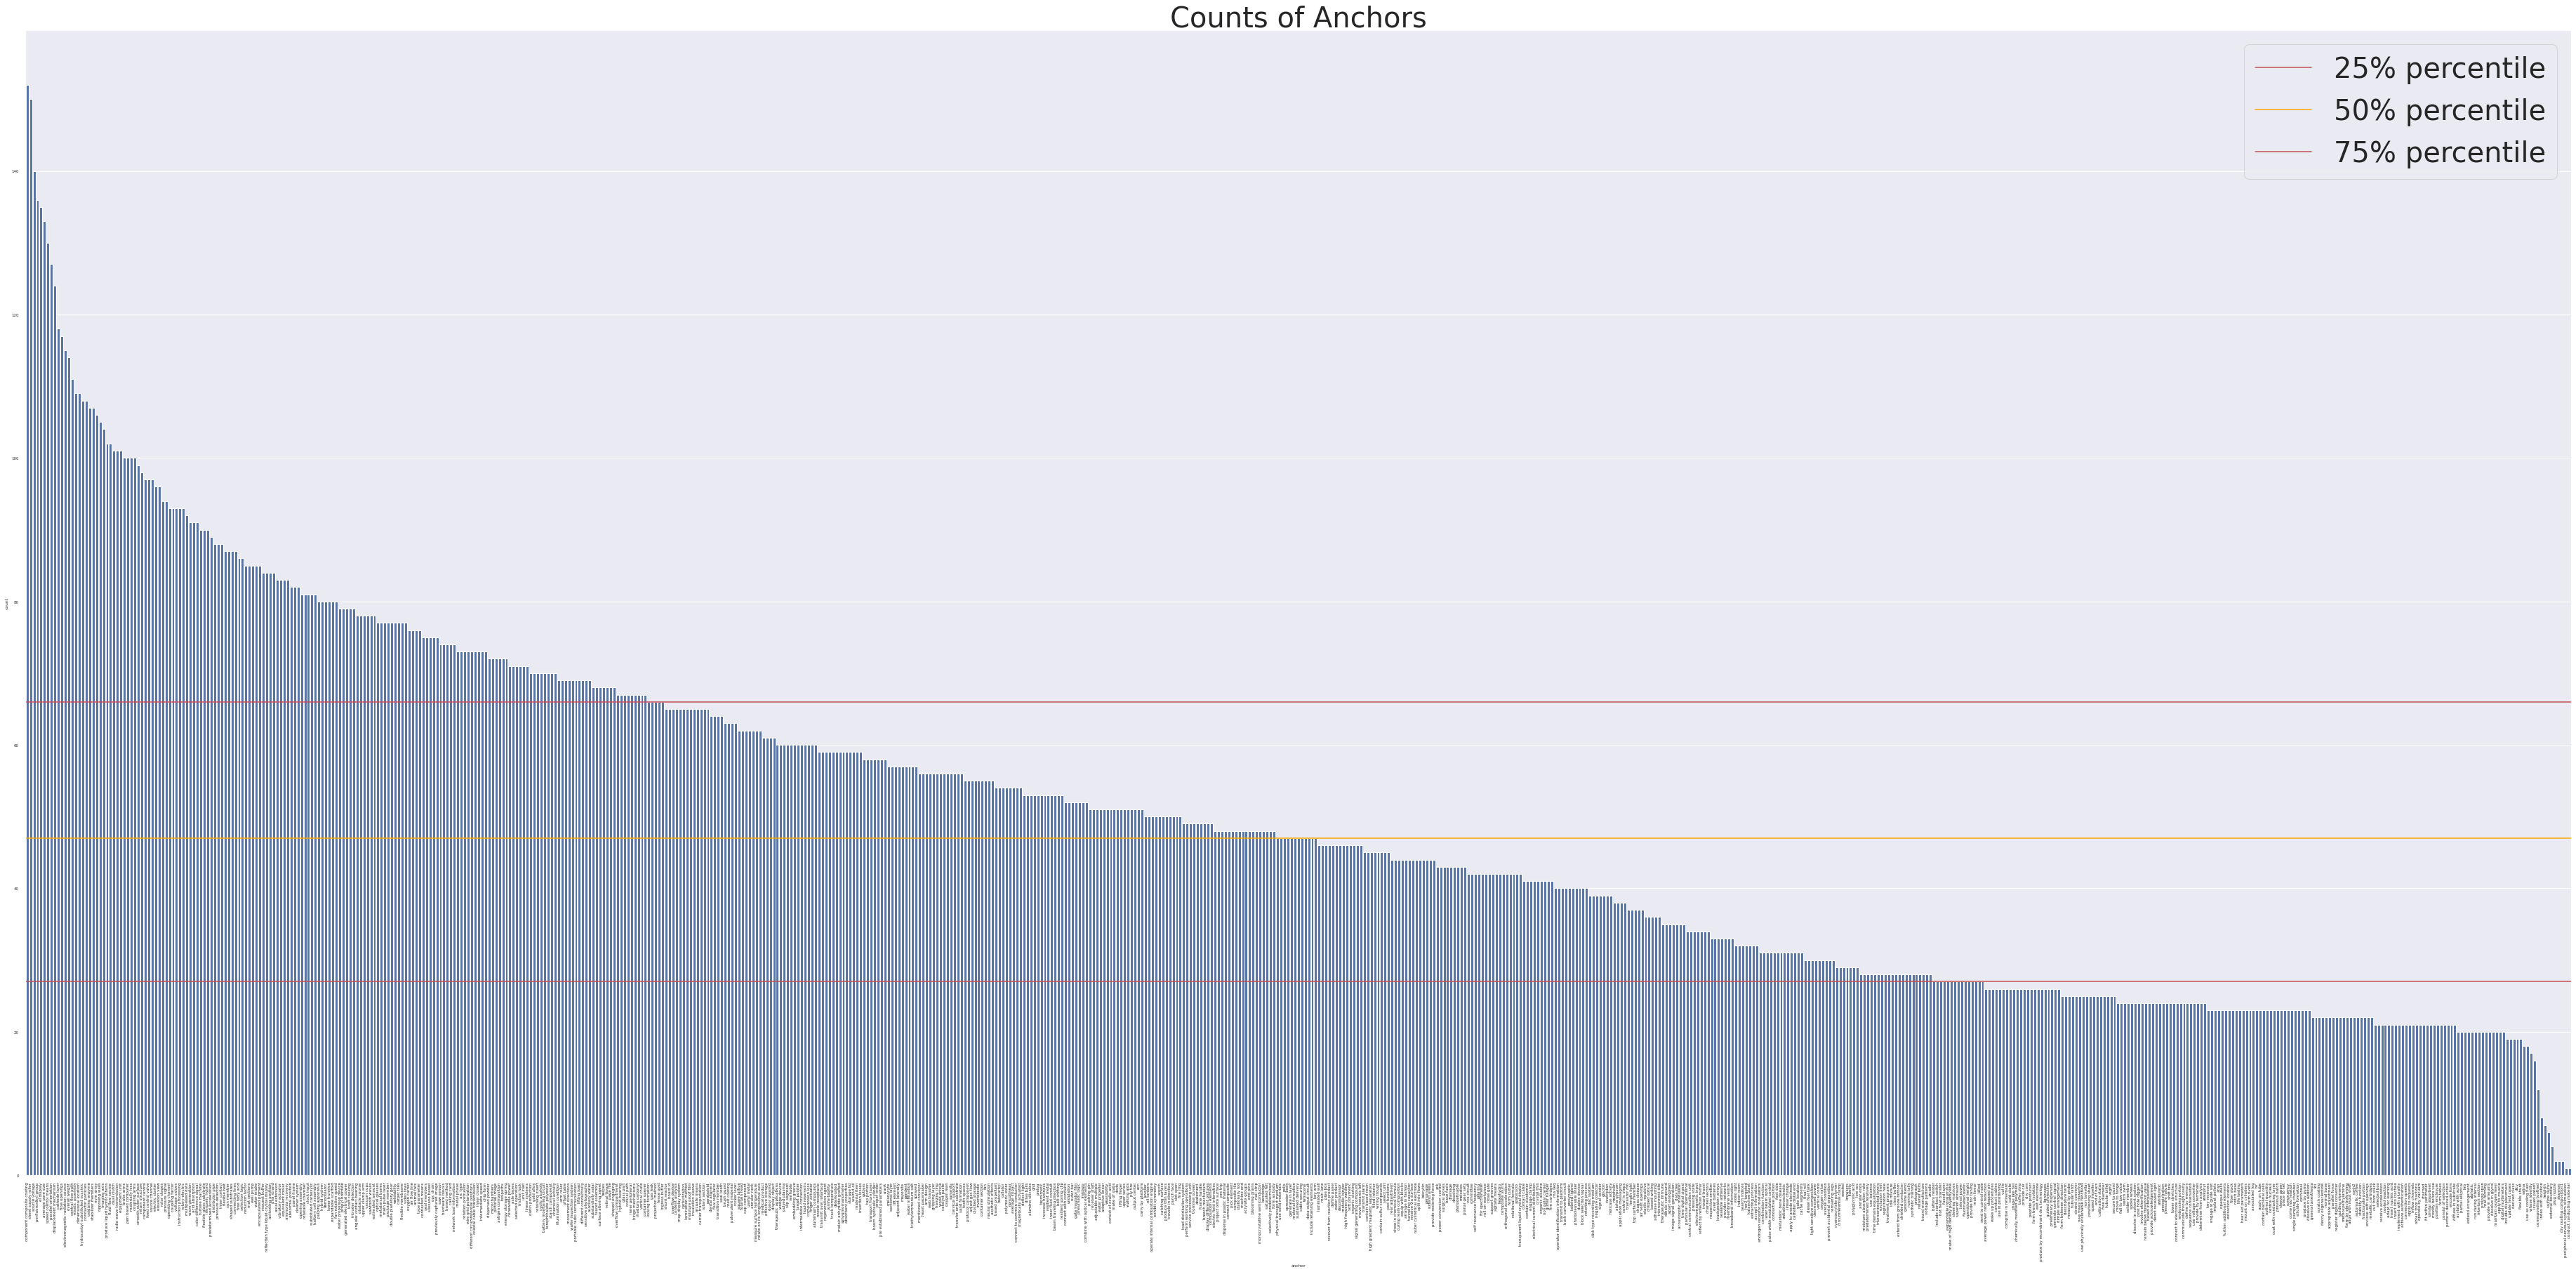

In [7]:
#tip: double clicking the plot will increase readability.
sns.set(font_scale = 0.5)
fig, ax =plt.subplots(figsize = (65,30))
sns.countplot(x = df.anchor, order = df.anchor.value_counts().index, ax = ax, color = "b")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.axhline(df.anchor.value_counts().reset_index().describe().loc["25%"][0], color = "r", label = "25% percentile")
ax.axhline(df.anchor.value_counts().reset_index().describe().loc["50%"][0], color = "orange", label = "50% percentile")
ax.axhline(df.anchor.value_counts().reset_index().describe().loc["75%"][0], color = "r", label = "75% percentile")
plt.title("Counts of Anchors", fontsize = 40)
plt.legend(fontsize=40)
#there are many values that are above the 3rd quartile and below the first quartile

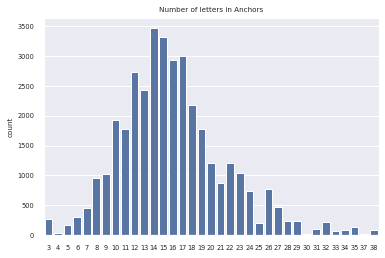

In [8]:
sns.set(font_scale = 0.6)
symbols = []
for i in df.anchor:
    symbols.append(len(i))

sns.countplot(x = symbols, color = "b")
plt.title("Number of letters in Anchors");
#the number of symbols in the anchor are normally distributed

Text(0.5, 1.0, 'Number of words in Anchors')

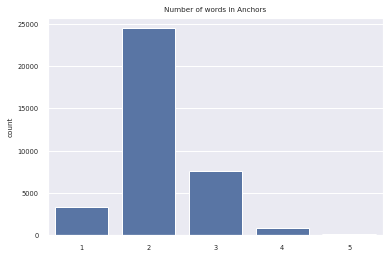

In [9]:
word_count = []
for i in df.anchor:
    word_count.append(len(i.split()))

sns.countplot(x = word_count, color = "b")
plt.title("Number of words in Anchors")
#the anchors contain 1-5 words; most of them contain 2 or 3 words

## Target

In [10]:
df.target.value_counts(), df.target.value_counts().reset_index().describe()

(composition                    24
 data                           22
 metal                          22
 motor                          22
 assembly                       21
                                ..
 switching switch over valve     1
 switching switch off valve      1
 switching over valve            1
 switching off valve             1
 wooden substrate                1
 Name: target, Length: 29340, dtype: int64,
              target
 count  29340.000000
 mean       1.243115
 std        0.925289
 min        1.000000
 25%        1.000000
 50%        1.000000
 75%        1.000000
 max       24.000000)

In [11]:
#Checking numbers in anchor feature
#Code from: https://www.kaggle.com/code/remekkinas/eda-and-feature-engineering/notebook

pattern = '[0-9]'
mask = df['anchor'].str.contains(pattern, na=False)
df['nun_anchor'] = mask
df[mask]['anchor'].value_counts()
#5 anchors contain numbers
#generally these names are rather cryptic

transistor m6               37
her2 targeted               32
vegfr2                      25
conh2                       22
dry coating composition1     2
Name: anchor, dtype: int64

In [12]:
df[df.anchor == "conh2"]
#there is a lot of domain knowledge necessary here

id anchor                                       target  \
6930  64e682c45465b95a  conh2                                   amide bond   
6931  aebe3be4febe6380  conh2                       amide functional group   
6932  7512a3fa79d6e4a8  conh2                          aminocarbonyl group   
6933  6eeec83a2b61bf26  conh2                    carbonyl functional group   
6934  ec2a14f057dc3f9c  conh2  carboxylic acid derivative functional group   
6935  919ce9549bab7139  conh2                             cistrans isomers   
6936  79ae2a3ac067f92e  conh2                                          con   
6937  c222e02ba32fd94b  conh2                                   confidence   
6938  12fb65b8dd150c25  conh2                                  consultancy   
6939  077d69289fb11043  conh2                                          coo   
6940  e00c36ec3d73729a  conh2                                  corn flakes   
6941  db4e9d5fff863bab  conh2                       covalent chemical bond   
6942  8b0dbaec9289072d  conh2                     dehydration condensation   
6943  0256afe42ed3297b  conh2                            functional groups   
6944  b47610a82b8a74b5  conh2                                h2n co moiety   
6945  eb06c685a806407f  conh2                            hydrochloric acid   
6946  c559a872456dc151  conh2                                 mineral acid   
6947  24980f7da9022bd3  conh2                          organic substituent   
6948  448a7760051edd54  conh2                                 peptide bond   
6949  593e34529336179c  conh2                                protein chain   
6950  6f8955224548408b  conh2                                sulfuric acid   
6951  c94e44fa0391da34  conh2                                   tetrazolyl   

     context  score  nun_anchor  
6930     C09   0.50        True  
6931     C09   0.75        True  
6932     C09   0.75        True  
6933     C09   0.25        True  
6934     C09   0.75        True  
6935     C09   0.25        True  
6936     C09   0.00        True  
6937     C09   0.00        True  
6938     C09   0.00        True  
6939     C09   0.00        True  
6940     C09   0.00        True  
6941     C09   0.50        True  
6942     C09   0.25        True  
6943     C09   0.25        True  
6944     C09   0.75        True  
6945     C09   0.00        True  
6946     C09   0.00        True  
6947     C09   0.25        True  
6948     C09   0.50        True  
6949     C09   0.50        True  
6950     C09   0.00        True  
6951     C09   0.25        True

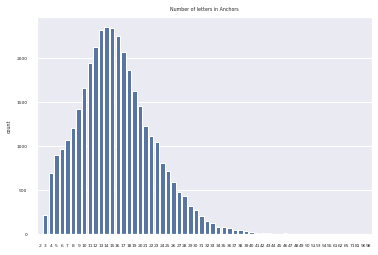

In [13]:
sns.set(font_scale = 0.4)
symbols = []
for i in df.target:
    symbols.append(len(i))

sns.countplot(x = symbols, color = "b")
plt.title("Number of letters in Anchors");
#the number of symbols in the target are (beautifully) normally distributed

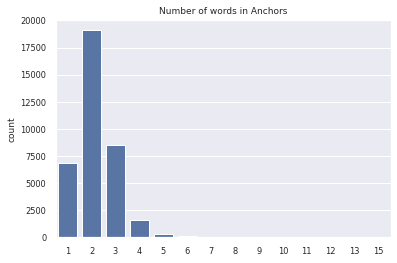

In [14]:
sns.set(font_scale = 0.75)
word_count = []
for i in df.target:
    word_count.append(len(i.split()))

sns.countplot(x = word_count, color = "b")
plt.title("Number of words in Anchors");
#the targets contain 1-15 words; most of them contain 1 to 3 words

## Context

In [15]:
#Dropping the int of the context to cluster on general category (called gen_cat)
df["gen_cat"] = 0
for index in df.index:
    df["gen_cat"].iloc[index] = df.context.iloc[index][0]

In [16]:
df.context.value_counts(), df.context.value_counts().reset_index().describe()

(H01    2186
 H04    2177
 G01    1812
 A61    1477
 F16    1091
        ... 
 B03      47
 F17      33
 B31      24
 A62      23
 F26      18
 Name: context, Length: 106, dtype: int64,
            context
 count   106.000000
 mean    344.084906
 std     404.682783
 min      18.000000
 25%     105.000000
 50%     191.500000
 75%     404.500000
 max    2186.000000)

In [17]:
#Checking numbers in target feature
#Code from: https://www.kaggle.com/code/remekkinas/eda-and-feature-engineering/notebook

pattern = '[0-9]'
mask = df['target'].str.contains(pattern, na=False)
df['num_target'] = mask
df[mask]['target'].value_counts()
#there are more values in target containing numbers, but they are always less frequent.

1 bromopropane                     2
consist of ethane 12 dioic acid    2
tetrahydro 1h imidazo              2
methyl 3h imidazo                  2
eastman g 3003                     2
                                  ..
expandable 3 d scaffolding         1
display 3 dimensional image        1
sio2 fillers                       1
3d position                        1
h2o product                        1
Name: target, Length: 112, dtype: int64

In [18]:
df[df.target == "h2o product"]
#this should have a higher score in my opinion.
#0.5 implies synonyms without the same meaning, I disagree on this score :)

id         anchor       target context  score  \
35699  54f72c05d5ebfbc7  water product  h2o product     C10    0.5   

       nun_anchor gen_cat  num_target  
35699       False       C        True

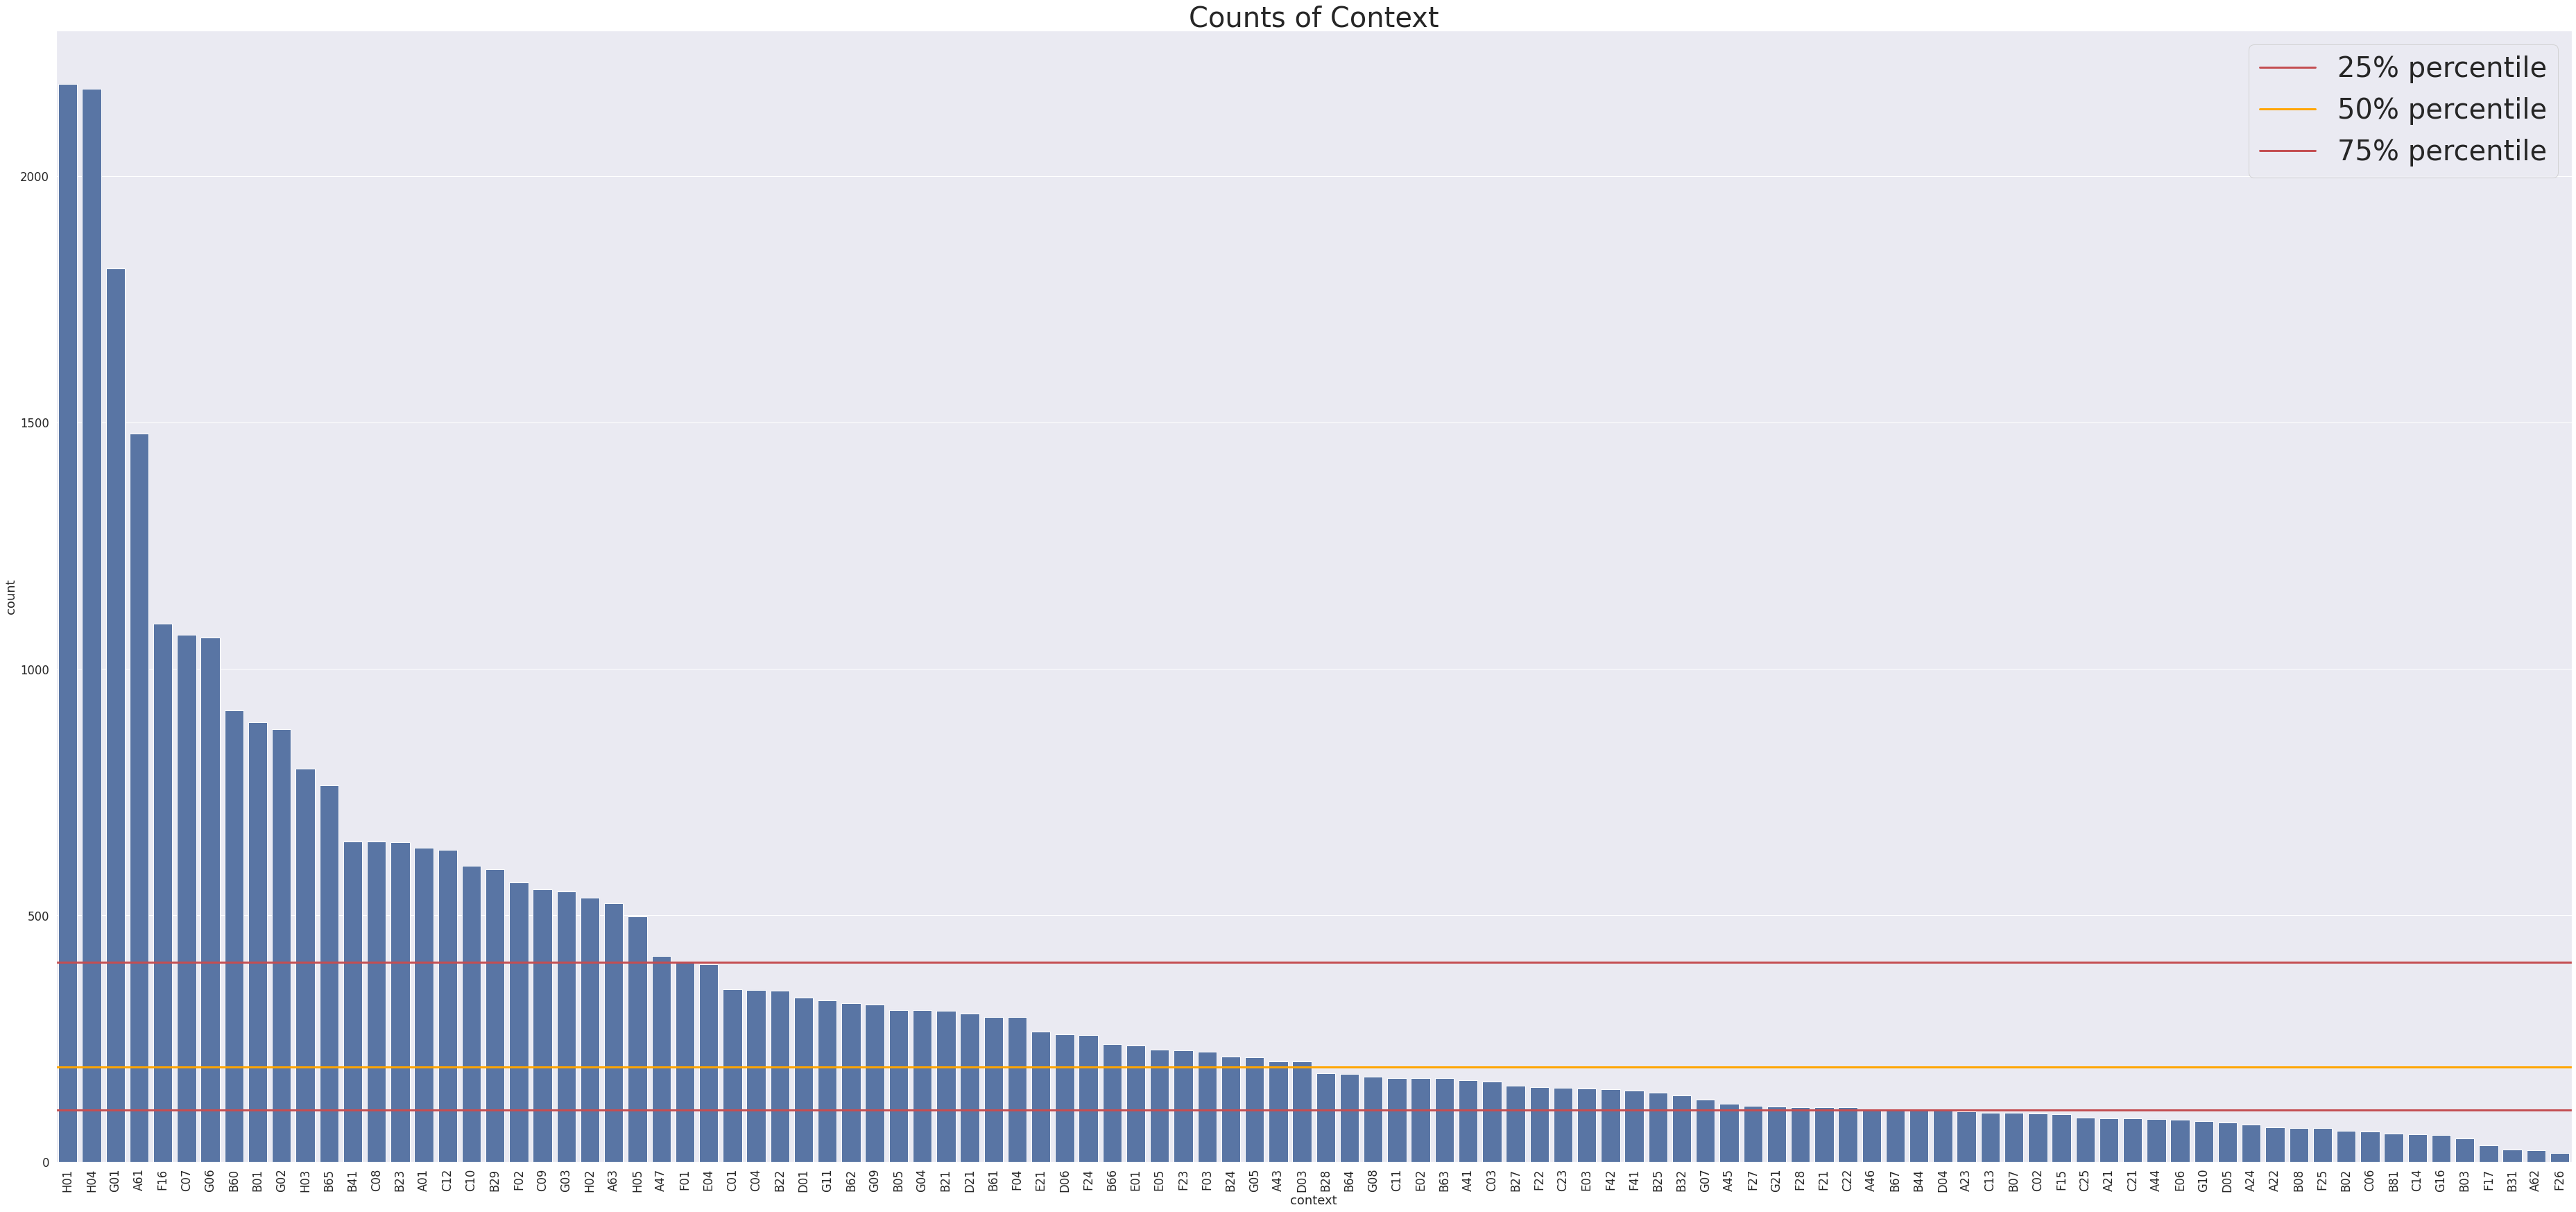

In [19]:
#tip: double clicking the plot will increase readability.
sns.set(font_scale = 1.5)
fig, ax =plt.subplots(figsize = (65,30))
sns.countplot(x = df.context, order = df.context.value_counts().index, ax = ax, color = "b")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.axhline(df.context.value_counts().reset_index().describe().loc["25%"][0], color = "r", linewidth = 3, label = "25% percentile")
ax.axhline(df.context.value_counts().reset_index().describe().loc["50%"][0], color = "orange",linewidth = 3, label = "50% percentile")
ax.axhline(df.context.value_counts().reset_index().describe().loc["75%"][0], color = "r", linewidth = 3, label = "75% percentile")
plt.title("Counts of Context", fontsize = 40)
plt.legend(fontsize=40)
#there are several values for context which heavily outweigh most other values

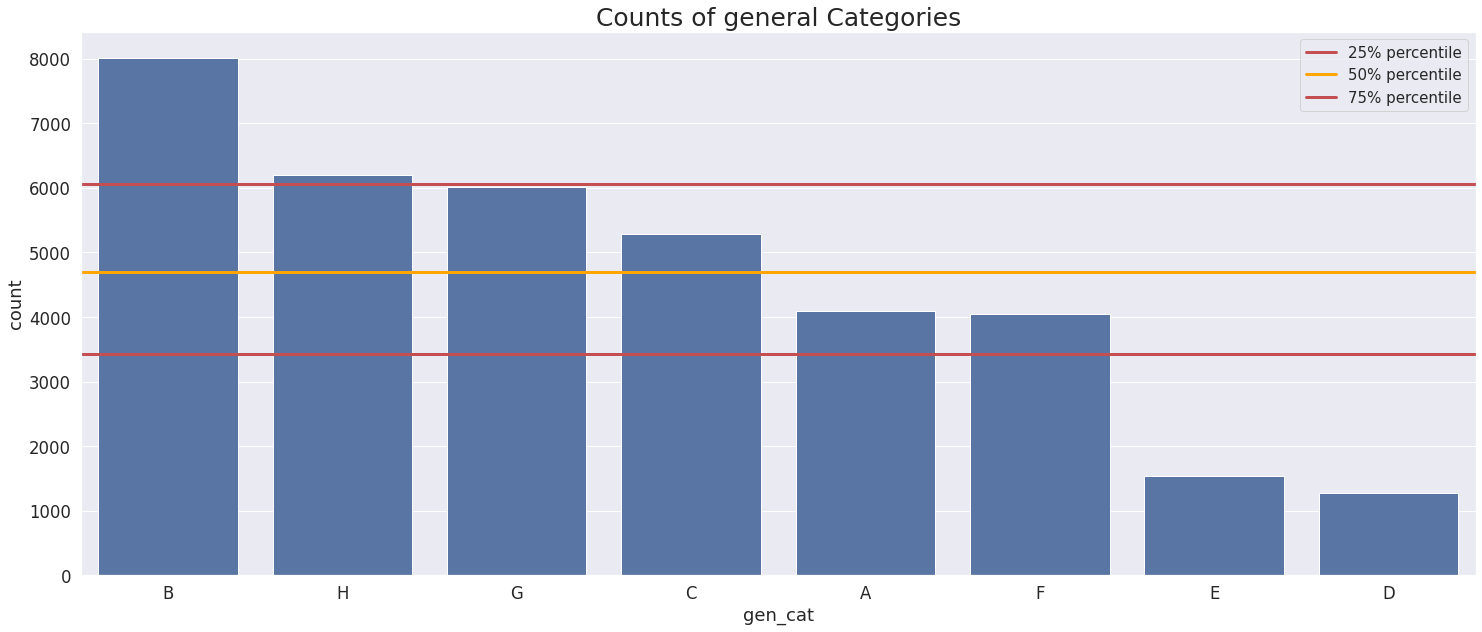

In [20]:
#tip: double clicking the plot will increase readability.
sns.set(font_scale = 1.5)
fig, ax =plt.subplots(figsize = (25,10))
sns.countplot(x = df.gen_cat, order = df.gen_cat.value_counts().index, ax = ax, color = "b")
ax.set_xticklabels(ax.get_xticklabels());
ax.axhline(df.gen_cat.value_counts().reset_index().describe().loc["25%"][0], color = "r", linewidth = 3, label = "25% percentile")
ax.axhline(df.gen_cat.value_counts().reset_index().describe().loc["50%"][0], color = "orange",linewidth = 3, label = "50% percentile")
ax.axhline(df.gen_cat.value_counts().reset_index().describe().loc["75%"][0], color = "r", linewidth = 3, label = "75% percentile")
plt.title("Counts of general Categories", fontsize = 25)
plt.legend(fontsize=15)
#unlike the individual contexts, the general contexts are more balanced
#However, there is only little context for the general categories E & D

In [21]:
#since there are many more anchors in the anchor-count plot than in the context-count plot, we know that some contexts
#have multiple anchors; at the same time: multiple contexts can also have the same anchor!
print(df[df.anchor == "activating position"].context.nunique(), df[df.anchor == "activating position"].gen_cat.nunique())
df[df.anchor == "activating position"]
#this example shows that some anchors are shared among contexts 
#(in this case 3 different contexts in 3 different general categories)

3 3


id               anchor              target context  score  \
483  6105b52e4bcf0abb  activating position             absence     A61   0.00   
484  c7fbcaa0df74f102  activating position           activator     A61   0.50   
485  94ce7cb98d619bba  activating position  activator position     A61   0.50   
486  a523f84ada6c4d21  activating position      activator site     A61   0.50   
487  47684a747ad281e7  activating position            aperture     A61   0.25   
..                ...                  ...                 ...     ...    ...   
562  3e0b9c50e903f63f  activating position    operative person     G06   0.00   
563  c8a232d8702877ad  activating position           positions     G06   0.50   
564  51da4ca78be17b5a  activating position      protected link     G06   0.25   
565  a8c0dfe520797e6f  activating position    routing topology     G06   0.50   
566  5b325222ada8449b  activating position    working position     G06   0.75   

     nun_anchor gen_cat  num_target  
483       False       A       False  
484       False       A       False  
485       False       A       False  
486       False       A       False  
487       False       A       False  
..          ...     ...         ...  
562       False       G       False  
563       False       G       False  
564       False       G       False  
565       False       G       False  
566       False       G       False  

[84 rows x 8 columns]

In [22]:
#How many unique contexts are given in train?
np.unique(df.context), f"{len(np.unique(df.context))} unique values"

(array(['A01', 'A21', 'A22', 'A23', 'A24', 'A41', 'A43', 'A44', 'A45',
        'A46', 'A47', 'A61', 'A62', 'A63', 'B01', 'B02', 'B03', 'B05',
        'B07', 'B08', 'B21', 'B22', 'B23', 'B24', 'B25', 'B27', 'B28',
        'B29', 'B31', 'B32', 'B41', 'B44', 'B60', 'B61', 'B62', 'B63',
        'B64', 'B65', 'B66', 'B67', 'B81', 'C01', 'C02', 'C03', 'C04',
        'C06', 'C07', 'C08', 'C09', 'C10', 'C11', 'C12', 'C13', 'C14',
        'C21', 'C22', 'C23', 'C25', 'D01', 'D03', 'D04', 'D05', 'D06',
        'D21', 'E01', 'E02', 'E03', 'E04', 'E05', 'E06', 'E21', 'F01',
        'F02', 'F03', 'F04', 'F15', 'F16', 'F17', 'F21', 'F22', 'F23',
        'F24', 'F25', 'F26', 'F27', 'F28', 'F41', 'F42', 'G01', 'G02',
        'G03', 'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11',
        'G16', 'G21', 'H01', 'H02', 'H03', 'H04', 'H05'], dtype=object),
 '106 unique values')

In [23]:
#How many unique contexts are given in test?
np.unique(test.context), f"{len(np.unique(test.context))} unique values"
#notably, there are many context values given in the training data, which are not contained in the test data
#However, this does not mean, that the final kaggle resut will not contain the missing 77 values!

(array(['A44', 'A61', 'A63', 'B01', 'B21', 'B22', 'B23', 'B60', 'B61',
        'B63', 'C07', 'C10', 'C12', 'C23', 'D06', 'E04', 'F01', 'F02',
        'F04', 'F16', 'F23', 'G01', 'G02', 'G05', 'G11', 'H02', 'H03',
        'H04', 'H05'], dtype=object),
 '29 unique values')

In [24]:
#Closer look at the contexts which only have a few entries
df[df.context == "F26"]
#it will probably be hard to train models on this little data.
#is there a way to arbitrarily increase the combinations for these contexts?

id          anchor                target context  score  \
22232  c8cc22d9f29c0a25  opposing walls            inner axis     F26   0.25   
22233  9f722314be051ca3  opposing walls          inner length     F26   0.25   
22234  dc202e2f124dd41f  opposing walls            inner wall     F26   0.50   
22235  6370b64cc3077f6c  opposing walls           inner walls     F26   0.50   
22236  26b60b1021b6061c  opposing walls         interior wall     F26   0.50   
22237  52f027f8f0bbf90c  opposing walls        interior walls     F26   0.50   
22238  2d880b708ac4091e  opposing walls                length     F26   0.25   
22239  c6a0bc8ef2f4128c  opposing walls               lengths     F26   0.25   
22240  a9203cc9c3c970db  opposing walls     longitudinal axis     F26   0.25   
22241  14b2c0f102d28a9e  opposing walls   longitudinal length     F26   0.25   
22242  6fd2fbc09bba9cd6  opposing walls   opposite inner wall     F26   0.50   
22243  bcde39881cdea931  opposing walls  opposite inner walls     F26   0.50   
22244  9e9fd37c14af9ddb  opposing walls       opposite length     F26   0.25   
22245  1c242ad34ec75d91  opposing walls        opposite sides     F26   0.25   
22246  e44e2dcbc9f97273  opposing walls        opposite walls     F26   1.00   
22247  d23713223cc6ec3e  opposing walls                 sides     F26   0.25   
22248  3574ac0f83df6a13  opposing walls             sidewalls     F26   0.50   
22249  76a0173e81e12b69  opposing walls                 walls     F26   0.50   

       nun_anchor gen_cat  num_target  
22232       False       F       False  
22233       False       F       False  
22234       False       F       False  
22235       False       F       False  
22236       False       F       False  
22237       False       F       False  
22238       False       F       False  
22239       False       F       False  
22240       False       F       False  
22241       False       F       False  
22242       False       F       False  
22243       False       F       False  
22244       False       F       False  
22245       False       F       False  
22246       False       F       False  
22247       False       F       False  
22248       False       F       False  
22249       False       F       False

In [25]:
#Closer look at the contexts which only have a few entries
df[df.context == "A62"]
#some of these word combinations seem wildly different.
#also, some of these word combinations seem again ambigiously placed: 
#matel phase -> metal of material = 0.5
#metal phase -> metal material = 0.25

id                anchor                        target  \
24     f6dfaebab0d209b7             abatement           pollution abatement   
14280  06dc4a2081a1cfe6              gas leak                         fault   
14281  b7375d56aa83dcdd              gas leak             gas leak detector   
14282  1c9a8a385b8b06aa              gas leak                          leak   
14283  50f3c19cf502ba9c              gas leak                   malfunction   
20079  30a16411e6e6120b           metal phase                bath component   
20080  0d32ea4383c46cf0           metal phase                 bath material   
20081  f41001ba56aded9c           metal phase                         metal   
20082  dd11588905da24a6           metal phase               metal component   
20083  3b333cfca640b1c1           metal phase                metal material   
20084  1970974e45dc17f1           metal phase             metal of material   
20085  168c7a2e230f0096           metal phase             metal oxide phase   
20086  497783898affe109           metal phase                  metal phases   
20087  737d0ca795cf5b43           metal phase           metal that material   
20088  bfb5b8de186ee9d9           metal phase                metallic phase   
20089  dc03a31b9d78dbaa           metal phase                       mixture   
20090  0637d65a863470f3           metal phase                         phase   
20091  f2aa98ea5d06d524           metal phase                          salt   
20092  3abe4cb861a771ca           metal phase              salt of material   
20093  4830785a859c852f           metal phase            salt that material   
20094  54621008b380c7c1           metal phase                    separation   
23882  a373ef3ca02b1538  perfluoroalkyl group  contain perfluoroalkyl group   
31586  4440b4f67917c6d0               sprayed               sprayed coating   

      context  score  nun_anchor gen_cat  num_target  
24        A62   0.50       False       A       False  
14280     A62   0.50       False       A       False  
14281     A62   0.50       False       A       False  
14282     A62   0.50       False       A       False  
14283     A62   0.50       False       A       False  
20079     A62   0.25       False       A       False  
20080     A62   0.25       False       A       False  
20081     A62   0.50       False       A       False  
20082     A62   0.50       False       A       False  
20083     A62   0.25       False       A       False  
20084     A62   0.50       False       A       False  
20085     A62   0.50       False       A       False  
20086     A62   1.00       False       A       False  
20087     A62   0.25       False       A       False  
20088     A62   1.00       False       A       False  
20089     A62   0.25       False       A       False  
20090     A62   0.50       False       A       False  
20091     A62   0.25       False       A       False  
20092     A62   0.25       False       A       False  
20093     A62   0.25       False       A       False  
20094     A62   0.25       False       A       False  
23882     A62   0.50       False       A       False  
31586     A62   0.50       False       A       False

In [26]:
list(df["gen_cat"].unique())
#we would expect B, E, F, G and H to be close to another! (just from general domains)

['A', 'C', 'F', 'H', 'B', 'D', 'E', 'G']

    A: Human Necessities
    B: Operations and Transport
    C: Chemistry and Metallurgy
    D: Textiles
    E: Fixed Constructions
    F: Mechanical Engineering
    G: Physics
    H: Electricity
    Y: Emerging Cross-Sectional Technologies

In [27]:
#Wordcloud per (general) context (most frequent words per context)
wc_a = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "A"].target))
wc_b = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "B"].target))
wc_c = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "C"].target))
wc_d = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "D"].target))
wc_e = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "E"].target))
wc_f = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "F"].target))
wc_g = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "G"].target))
wc_h = WordCloud(width = 800, height = 400, background_color="white").generate(" ".join(target for target in df[df.gen_cat == "H"].target))

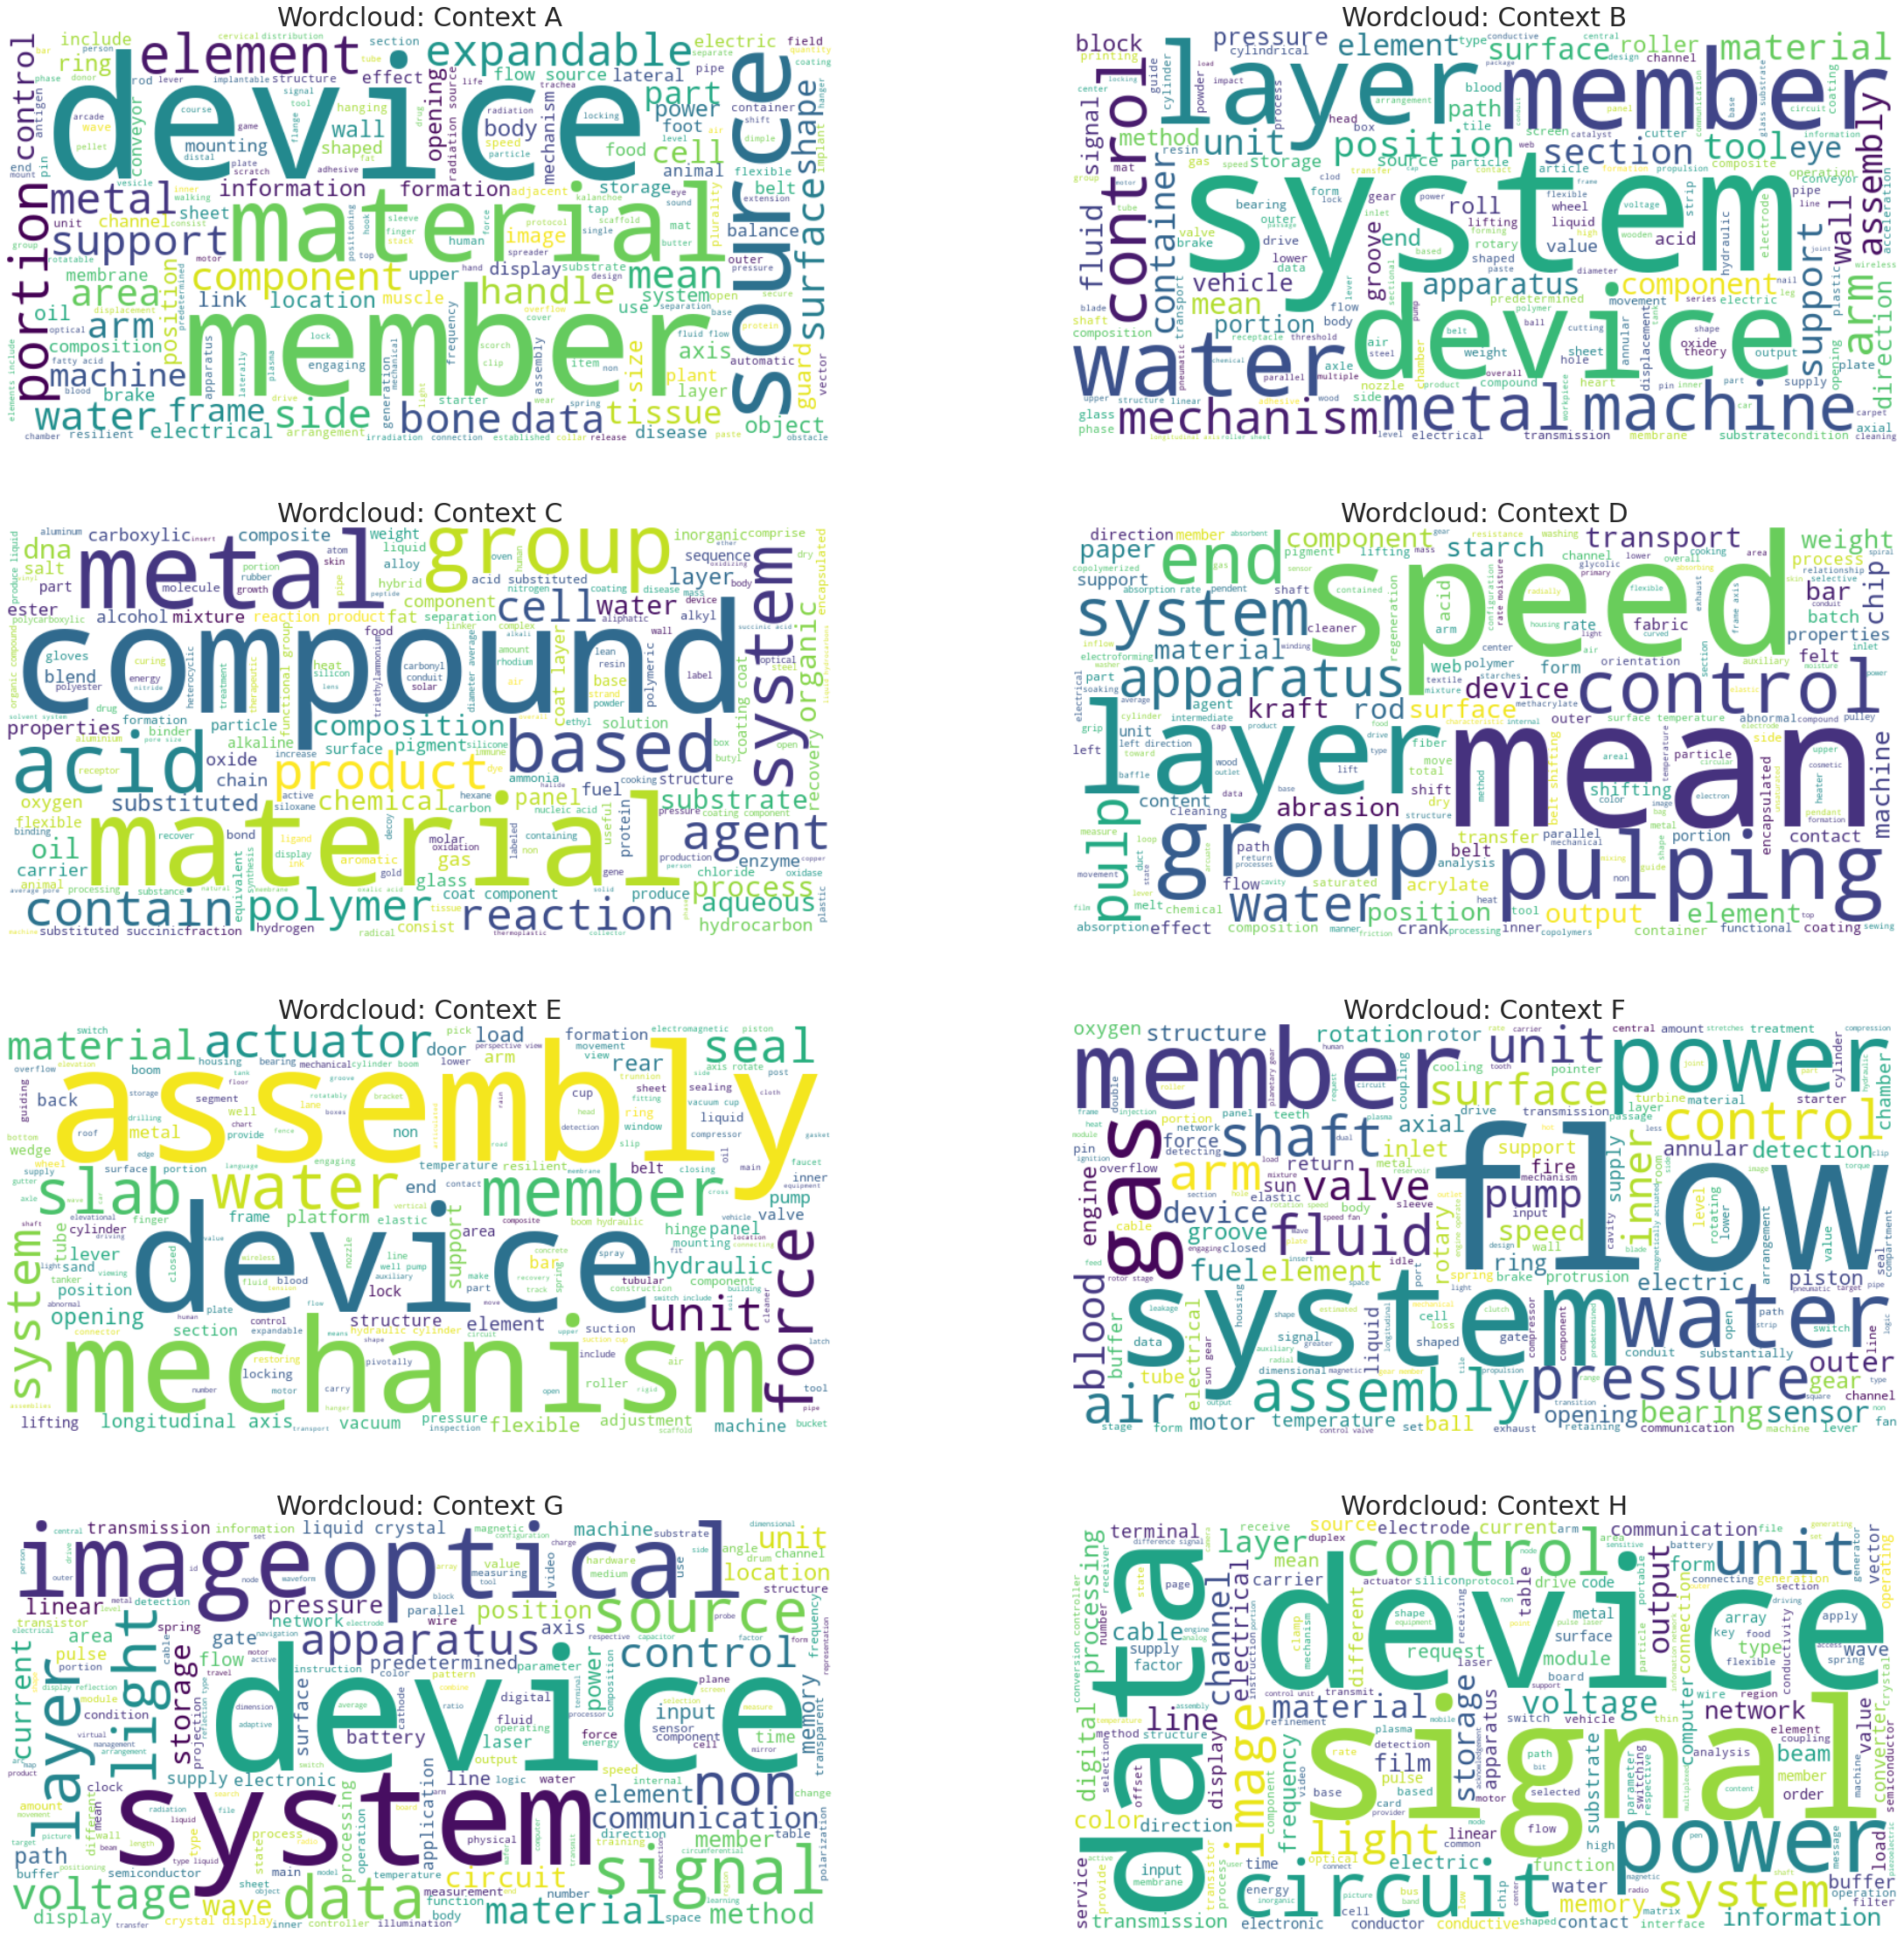

In [28]:
#Show the wordclouds
fig = plt.figure(figsize = (40,40))
ims = [[wc_a, "Wordcloud: Context A"],
       [wc_b, "Wordcloud: Context B"],
       [wc_c, "Wordcloud: Context C"],
       [wc_d, "Wordcloud: Context D"],
       [wc_e, "Wordcloud: Context E"],
       [wc_f, "Wordcloud: Context F"],
       [wc_g, "Wordcloud: Context G"],
       [wc_h, "Wordcloud: Context H"]]

for a, b in enumerate(ims):
    fig.add_subplot(4,2, a+1)
    plt.imshow(b[0], interpolation='bilinear')
    plt.title(b[1], fontsize = 30)
    plt.axis("off")
    
#Double-clicking may increase readability :) 
#Lets quickly look at the first things we can notice:
    #Looking at the wordcloud, we see the word "device" being common in context A, B, E, G, H
    #Context B and D both have the word "layer" as common occurence
    #Context B, D, E and F all have the word "water" as common occurence
    #Context A, B, E and F all have the word "member" as common occurence
    #Context B and C both have the word "metal" as common occurence
#In result, none of the wordclouds are fully disconnected from the others
    #C seems "the most disconnected"

In [29]:
#Lengths of target per context
df["target_length"] = 0
for i in df.index:
    df.target_length.iloc[i] = len(df.target.iloc[i].split())

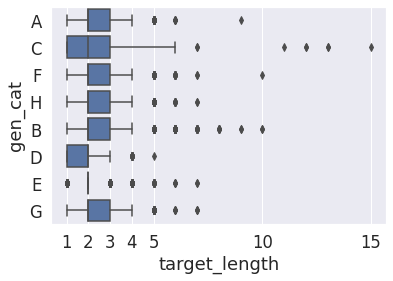

In [30]:
sns.boxplot(x = "target_length", y = "gen_cat", data = df, color = "b")
plt.xticks([1,2,3,4,5, 10, 15]);
#most context categories are in the area of 2-3 words for target
#C has the relative-most longest targets
# C and D have the relative-most shortest targets

<AxesSubplot:xlabel='target_length', ylabel='context'>

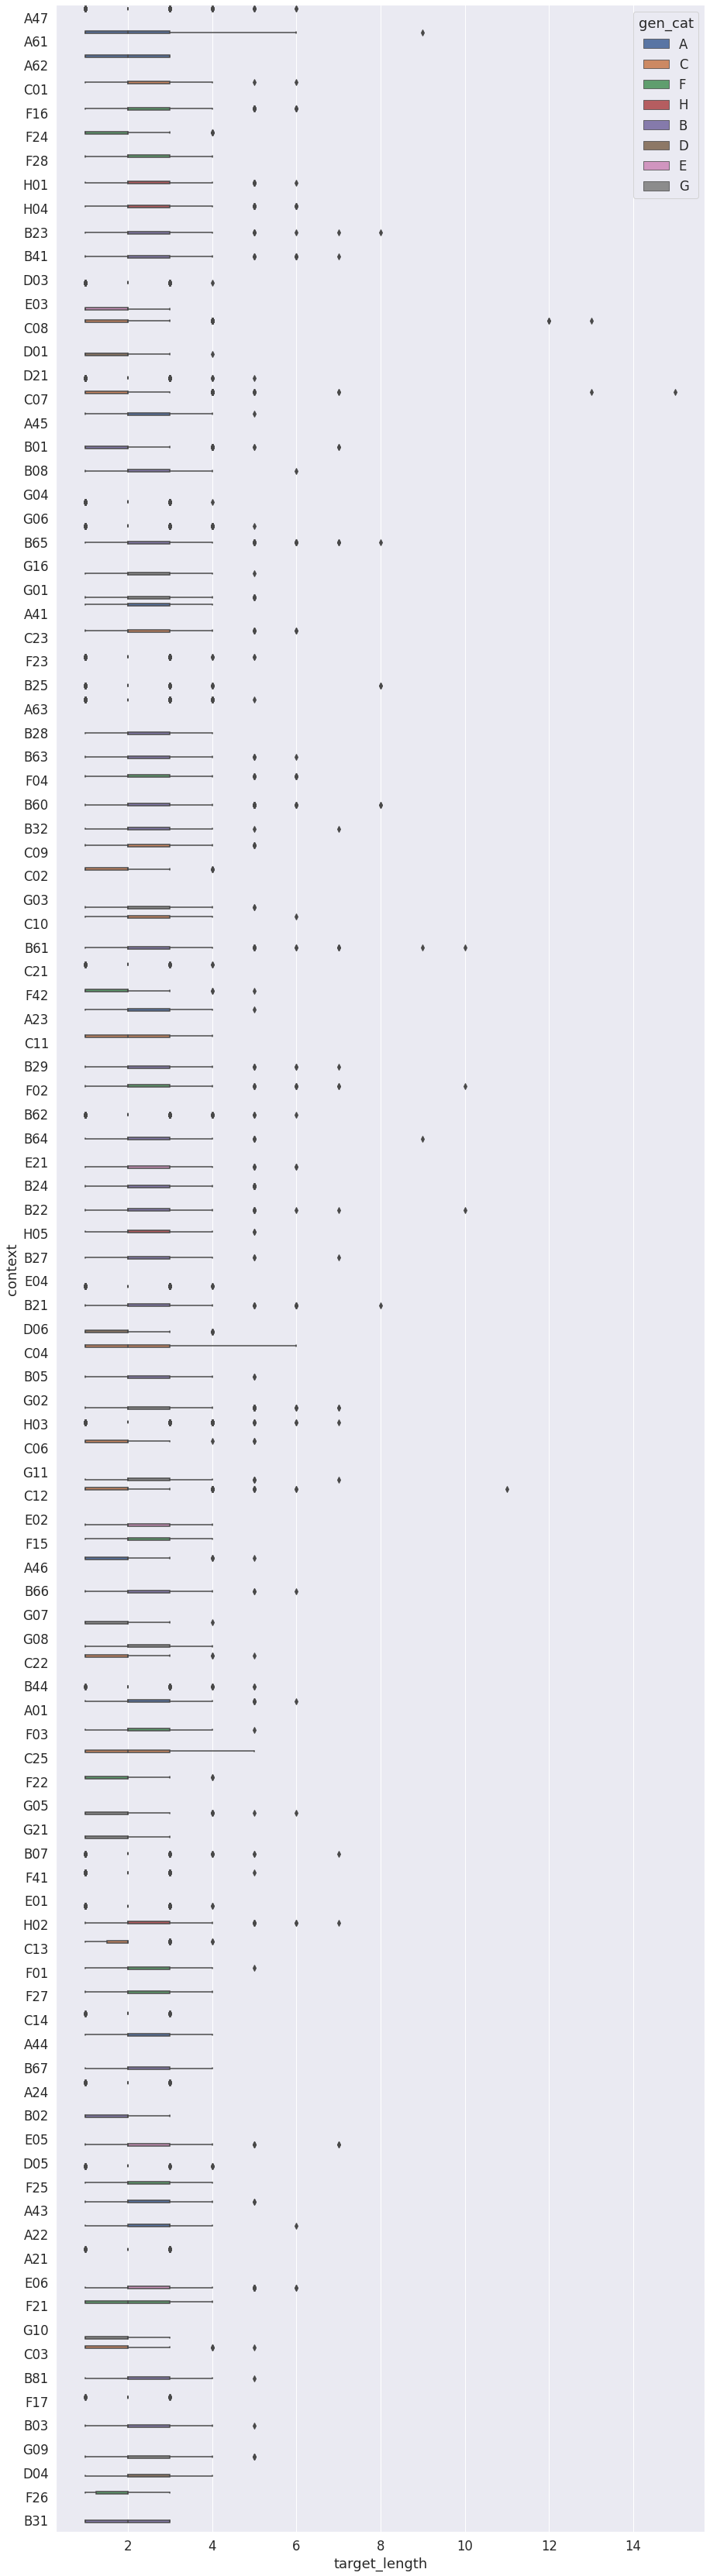

In [31]:
fig = plt.figure(figsize = (15,60))
sns.boxplot(x = "target_length", y = "context", data = df, hue = "gen_cat")
#interestingly some contexts (such as C07 and C08) are very short but also have the strongest outliers
#we can see that the sub categories' context-length are often similar within their categories

In [32]:
#Looking at these word lengths, lets have a look at the scores they receive
#(because maybe they have a terrible score just because of the lengths)
df[df.target_length >= 6].head(25)

id                         anchor  \
356   bbcfc92543e58f1e                acid absorption   
830   4cf4a1d17fd999a7            adjustable multiple   
1021  e45d14ae26078f30                  air flow line   
1118  0e1570332414662c                   alpha gypsum   
1900  56b03ab7b1efe0c3              apply to requests   
2306  62a505b8cd105022                 associated log   
2753  c31c770b8ee191d2                     axle boxes   
2987  cb5a33e139179ac9                   based method   
3028  f4c178c9789f184c               based propellant   
3041  98b74ef50ff80e12               based propellant   
3402  553f62d5a2cb0f8f                       biocytin   
3491  278b11538b246426         block selection signal   
3833  813187a9485496a5               breech mechanism   
3834  9d3cde1f06def1bc               breech mechanism   
5665  0b4c5293c56b9775                          clods   
5705  c0221f9b436a52f7                     close gate   
6074  2112c5cfd1a047af  combine with optical elements   
6528  e7cd6d0834e5e1ea              component control   
6746  e6d0826ac3d89e50                 conduct cables   
7341  8e57427fcc150b59         consist of oxalic acid   
7369  10297eba7071af66         consist of oxalic acid   
7419  90aad8c7dbb67a35                  contact cable   
7499  612c4b2992c0029c            contain based resin   
8228  feb725db056e2ede          cyanoacrylate polymer   
8346  d34165be2d576062                     dac system   

                                                 target context  score  \
356   steel structural member cleaning maintenance d...     B08   0.25   
830           multiple disease of the brain spinal cord     B23   0.00   
1021                     line graph of the road network     F04   0.00   
1118        heating of gypsum stone under high pressure     B32   0.75   
1900               apply to both requests and responses     H04   0.75   
2306                     length of a cut or fallen tree     B27   0.75   
2753                 test tube box for blood collection     E21   0.00   
2987                   compared to not using the method     H04   0.25   
3028   a substance used as a reagent in a rocket engine     F02   0.75   
3041     data based on the access frequency information     F02   0.00   
3402  2s 6 5 3as4s6ar 2 oxo 133a466a hexahydrothieno...     C07   0.75   
3491             block system of hybrid seed production     B41   0.00   
3833     loading sequence of a breech loading naval gun     B25   0.75   
3834     loading sequence of a breech loading small arm     B25   0.75   
5665           frost is essential for breaking up clods     B07   0.00   
5705           automatic open close eye protective lens     B65   0.00   
6074     combine with optical elements of the headlight     G02   0.75   
6528                 electric drive for a baby carriage     B62   0.25   
6746           cam shaft in internal combustion engines     F16   0.25   
7341                    consist of ethane 12 dioic acid     C04   0.75   
7369                    consist of ethane 12 dioic acid     C23   0.75   
7419  railway location information management networ...     B61   0.25   
7499             containing an olefin based polymer wax     H01   0.50   
8228             family of strong fast acting adhesives     B41   0.50   
8346            sigma delta digital to analog converter     H03   0.50   

      nun_anchor gen_cat  num_target  target_length  
356        False       B       False              6  
830        False       B       False              7  
1021       False       F       False              6  
1118       False       B       False              7  
1900       False       H       False              6  
2306       False       B       False              7  
2753       False       E       False              6  
2987       False       H       False              6  
3028       False       F       False             10  
3041       False       F       False              7  
3402       False  

<AxesSubplot:title={'center':'score'}, xlabel='target_length'>

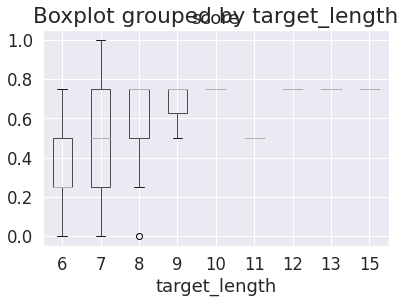

In [33]:
df[df.target_length >= 6].boxplot(column = "score", by = "target_length")
#it seems like longer targets will not be able to receive full score

In [34]:
df[(df.target_length >= 6) & (df.score == 1)]
#the only case of a perfect score has a very long anchor itself (so its only 2 words longer)

id                                  anchor  \
27328  4b6e7138c56d7a99  reflection type liquid crystal display   

                                                  target context  score  \
27328  total reflection type liquid crystal display p...     G02    1.0   

       nun_anchor gen_cat  num_target  target_length  
27328       False       G       False              7

In [35]:
#Maybe instead of looking at absolute lengths, we should look at relative lengths compared to the anchor
df["length_diff"] = 0
for i in df.index:
    df.length_diff.iloc[i] = df["target_length"].iloc[i] - len(df.anchor.iloc[i].split())

<AxesSubplot:title={'center':'score'}, xlabel='length_diff'>

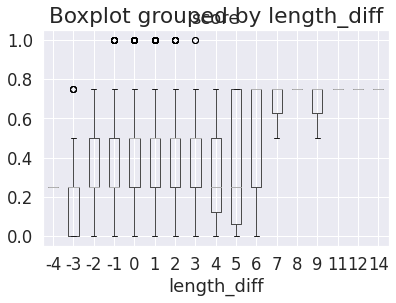

In [36]:
df.boxplot(column = "score", by = "length_diff")
#it seems like a length difference of more than 3 and lower than -2 will not allow a perfect score
#while it seems that the target being way shorter than the anchor is generally bad for score
#the target being longer than the anchor seems to generally have a positive impact

#these findings need to be looked at with some respect, though, given that there are only few data points, on which this data is based on
# Accordingly, this may be completely different for unknown test data

## Score

<AxesSubplot:xlabel='score'>

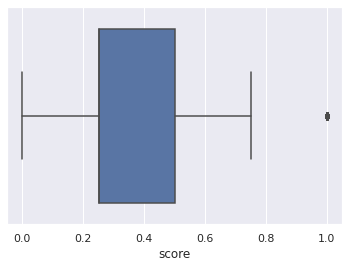

In [37]:
sns.set(font_scale = 1)
sns.boxplot(x = df.score)

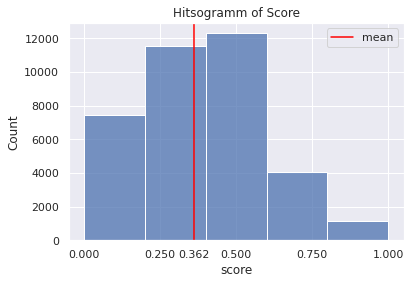

In [38]:
sns.histplot(x = df.score, bins = 5)
plt.xticks([0.0, 0.25, np.mean(df.score), 0.5, 0.75, 1.0]);
plt.axvline(np.mean(df.score), color = "red", label = "mean")
plt.legend()
plt.title("Hitsogramm of Score");

In [39]:
#Which entries have a score of 1?
df[df.score == 1].head(15)
#it seems like patents with the same anchor and target have sometimes different context (B65 & G06; A41 & B23)

id                anchor                     target  \
28   473137168ebf7484             abatement                    abating   
158  621b048d70aa8867  absorbent properties  absorbent characteristics   
161  bc20a1c961cb073a  absorbent properties      absorption properties   
311  e955700dffd68624       acid absorption         absorption of acid   
315  3a09aba546aac675       acid absorption            acid absorption   
509  4f24e6d79cc0c22b   activating position         activated position   
514  80f111f091cf8e4d   activating position        activating position   
518  f99a2b6f5aac24bc   activating position        activation position   
538  167d7f4323fdf14a   activating position         activated position   
542  b5d1c49fb280b4eb   activating position       activating positions   
546  11999f823ace67f2   activating position        activation position   
635  c7981eb2712b238c       adaptive linear            adapting linear   
665  7920ba9fb0bf4578     adhesive mounting             adhesive mount   
713  f3d0de522d259188    adjacent laterally         laterally adjacent   
730  8e5d59e9cf2f6c24    adjacent laterally         adjacent laterally   

    context  score  nun_anchor gen_cat  num_target  target_length  length_diff  
28      F24    1.0       False       F       False              1            0  
158     D01    1.0       False       D       False              2            0  
161     D01    1.0       False       D       False              2            0  
311     B08    1.0       False       B       False              3            1  
315     B08    1.0       False       B       False              2            0  
509     B65    1.0       False       B       False              2            0  
514     B65    1.0       False       B       False              2            0  
518     B65    1.0       False       B       False              2            0  
538     G06    1.0       False       G       False              2            0  
542     G06    1.0       False       G       False              2            0  
546     G06    1.0       False       G       False              2            0  
635     H04    1.0       False       H       False              2            0  
665     A47    1.0       False       A       False              2            0  
713     A41    1.0       False       A       False              2            0  
730     B23    1.0       False       B       False              2            0

In [40]:
#How many are there per context group?
context_counts = df[df.score == 1].groupby("context").id.count().reset_index().sort_values("id", ascending = False)
context_counts

context  id
98     H04  62
36     B65  61
72     F16  56
31     B60  47
83     G01  44
..     ...  ..
44     C06   1
62     E03   1
79     F26   1
78     F25   1
60     E01   1

[100 rows x 2 columns]

In [41]:
#context groups where there is only one patent with the score 1.0
list(context_counts[context_counts.id == 1].context)

['A22', 'C11', 'A43', 'A44', 'C06', 'E03', 'F26', 'F25', 'E01']

In [42]:
df[df.context == "A22"].head(20)
#maybe turning word groups into syllables will help in prediction
#alternatively, it probably makes sense to reduce key words in to their parts for abbreviations
#such as electromagnectic -> electro magnetic -> em  

id                            anchor  \
11041  0b3fc507d78eb425  electromagnetic radiation source   
11042  f45901e6a8a7885f  electromagnetic radiation source   
11043  8bb41528d69414d6  electromagnetic radiation source   
11044  501a41137d524473  electromagnetic radiation source   
11045  0abf89fb36e0a5ef  electromagnetic radiation source   
11046  5e192d323ce08153  electromagnetic radiation source   
11047  365dc54d395cb34a  electromagnetic radiation source   
11048  46f34bbd7e640e1c  electromagnetic radiation source   
11049  91561ab5b22ae375  electromagnetic radiation source   
11050  7d9eeb7ee5237352  electromagnetic radiation source   
11051  a81880ca970cdf7e  electromagnetic radiation source   
11052  b573b70fe84c1e23  electromagnetic radiation source   
11053  b011f7ac4549a3f4  electromagnetic radiation source   
11054  ef5dd2e8f18e0b8f  electromagnetic radiation source   
11055  5860be03c84e132d  electromagnetic radiation source   
11056  15f77915a2311a90  electromagnetic radiation source   
11057  103b0c9a46e0537b  electromagnetic radiation source   
11058  44babd44c985d80f  electromagnetic radiation source   
11059  42f4bc4c786febc0  electromagnetic radiation source   
11060  3671219d9375e7bf  electromagnetic radiation source   

                                           target context  score  nun_anchor  \
11041                    electromagnetic em field     A22   0.50       False   
11042                   electromagnetic induction     A22   0.00       False   
11043                 electromagnetic irradiation     A22   0.50       False   
11044       electromagnetic irradiation radiation     A22   0.50       False   
11045          electromagnetic irradiation source     A22   0.75       False   
11046                electromagnetic light source     A22   0.50       False   
11047               electromagnetic light sources     A22   0.50       False   
11048              electromagnetic radiant energy     A22   0.50       False   
11049           electromagnetic radiation sources     A22   1.00       False   
11050                      electromagnetic source     A22   0.50       False   
11051                             em light source     A22   0.50       False   
11052                         em radiation source     A22   0.75       False   
11053                        em radiation sources     A22   0.75       False   
11054                                   em source     A22   0.75       False   
11055  exemplary electromagnetic radiation device     A22   0.50       False   
11056  exemplary electromagnetic radiation source     A22   0.75       False   
11057            exemplary electromagnetic source     A22   0.50       False   
11058     exemplary electromagnetic source device     A22   0.50       False   
11059                  exemplary radiation device     A22   0.50       False   
11060                  exemplary radiation source     A22   0.50       False   

      gen_cat  num_target  target_length  length_diff  
11041       A       False              3            0  
11042       A       False              2           -1  
11043       A       False              2           -1  
11044       A       False              3            0  
11045       A       False              3            0  
11046       A       False              3            0  
11047       A       False              3            0  
11048       A       False              3            0  
11049       A       False              3            0  
11050       A       False              2           -1  
11051       A       False              3            0  
11052       A       False              3            0  
11053       A       False              3            0  
11054       A       False              2           -1  
11055       A       False              4            1  
11056       A       False              4            1  
11057       A       False              3            0  
11058       A       False              4          

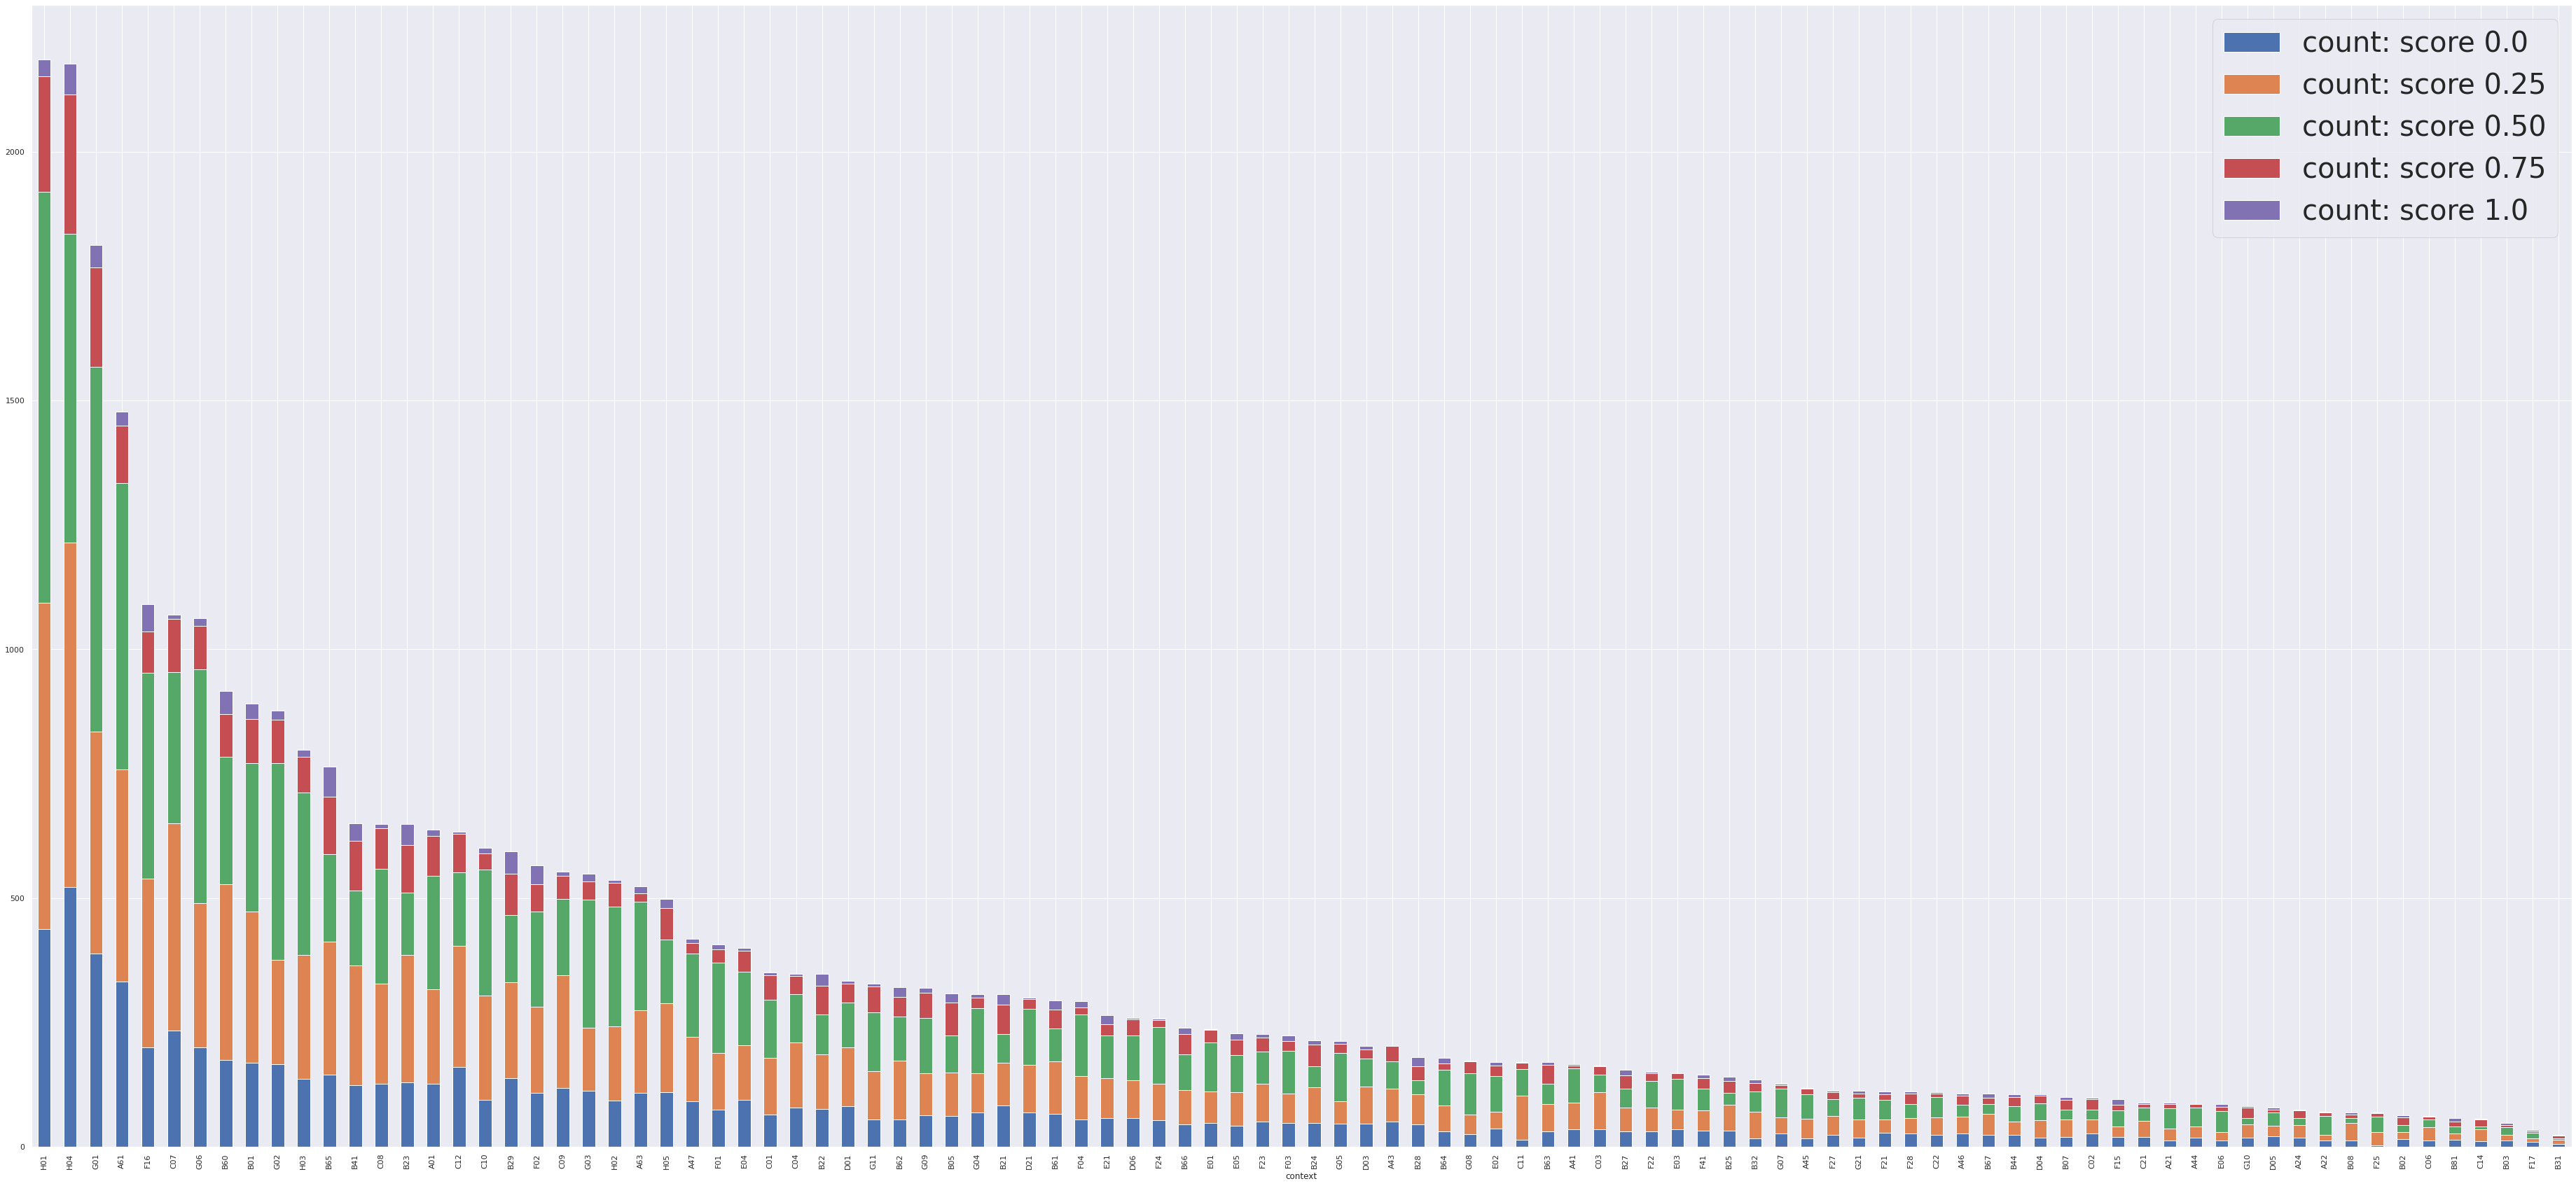

In [43]:
#Creating this dataframe for a stacked barchart is tidious but mostly copy-paste
scores_plot = df[df.score == 0].groupby(["context"]).id.count().reset_index()
scores_plot.columns = ["context","count_score_0"]
scores_plot = scores_plot.merge(df[df.score == 0.25].groupby(["context"]).id.count().reset_index(), on = "context")
scores_plot = scores_plot.merge(df[df.score == 0.50].groupby(["context"]).id.count().reset_index(), on = "context")
scores_plot = scores_plot.merge(df[df.score == 0.75].groupby(["context"]).id.count().reset_index(), on = "context")
scores_plot = scores_plot.merge(df[df.score == 1].groupby(["context"]).id.count().reset_index(), on = "context")
scores_plot = scores_plot.merge(df.groupby("context").id.count().reset_index(), on = "context")
scores_plot.columns = ["context", "count: score 0.0", "count: score 0.25", "count: score 0.50", "count: score 0.75", "count: score 1.0", "overall"]
scores_plot = scores_plot.sort_values("overall", ascending = False).set_index("context")
scores_plot.drop(columns = ["overall"], inplace = True)

#Creating the stacked barchart for scores
fig, ax =plt.subplots(figsize = (65,30))
scores_plot.plot(kind = "bar", stacked = True, ax = ax)
plt.legend(fontsize = 40)
#This plot underlines how rare perfect scores are and how very common 0.25 and 0.5 are as score.

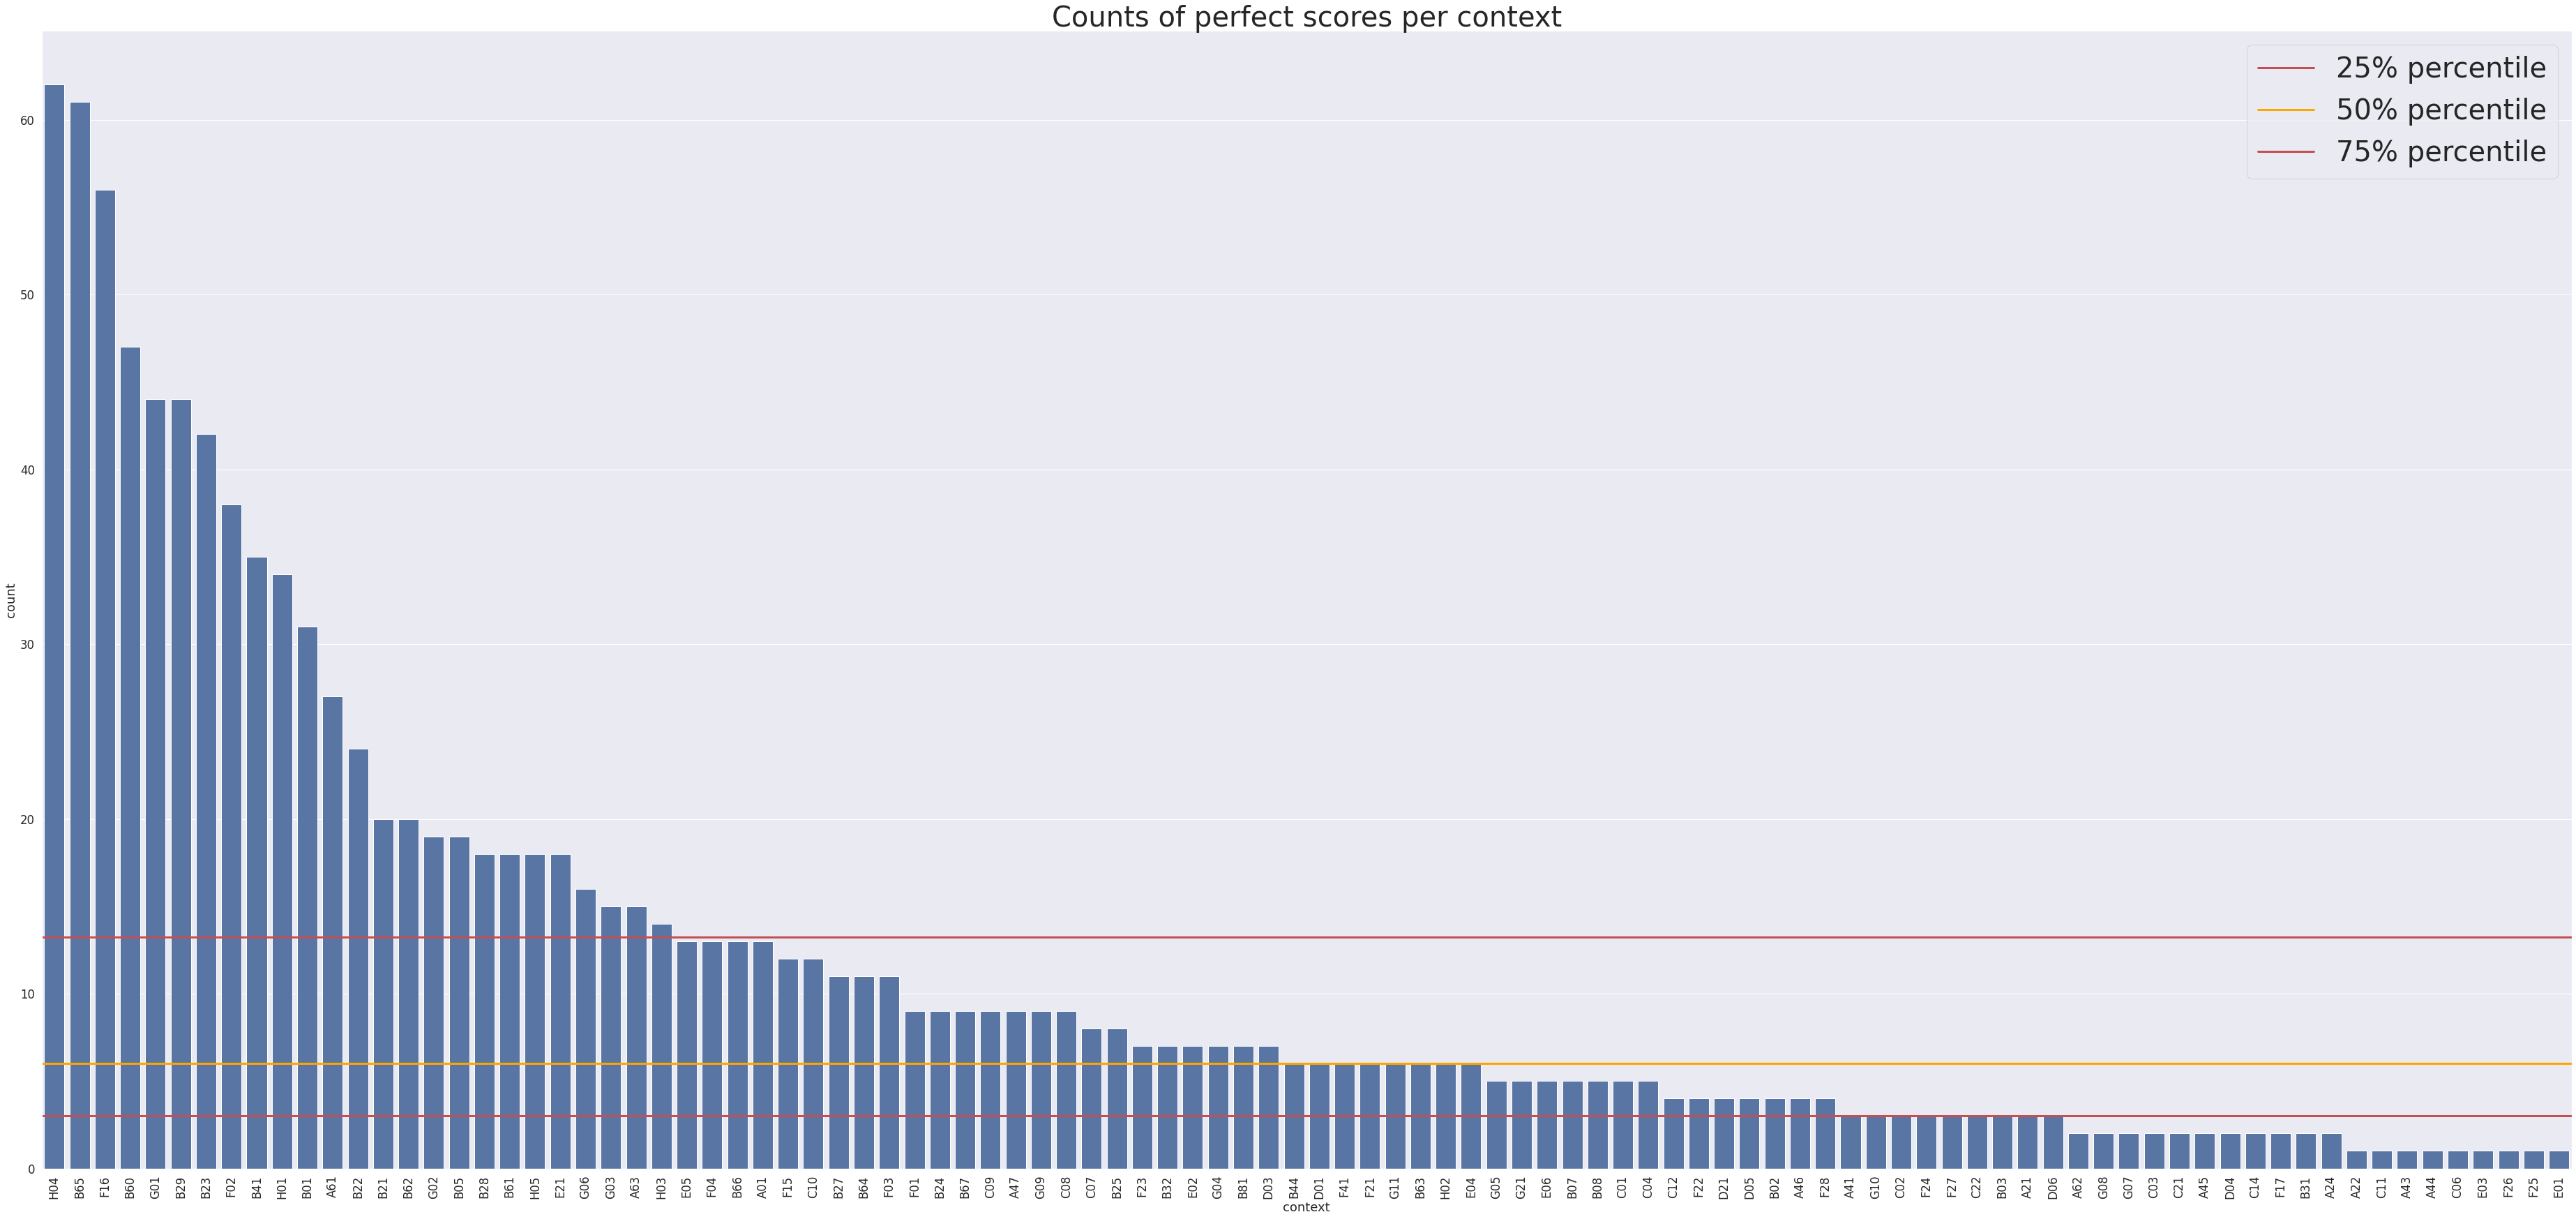

In [44]:
perfect_scores = df[df.score == 1].groupby("context").id.count().reset_index().sort_values("id", ascending = False)

#tip: double clicking the plot will increase readability.
sns.set(font_scale = 1.5)
fig, ax =plt.subplots(figsize = (65,30))
sns.barplot(x = "context", y ="id", data = perfect_scores, ax = ax, color = "b")
sns.barplot(x = "context", y ="id", data = perfect_scores, ax = ax, color = "b")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.axhline(perfect_scores.describe().loc["25%"][0], color = "r", linewidth = 3, label = "25% percentile")
ax.axhline(perfect_scores.describe().loc["50%"][0], color = "orange",linewidth = 3, label = "50% percentile")
ax.axhline(perfect_scores.describe().loc["75%"][0], color = "r", linewidth = 3, label = "75% percentile")
plt.title("Counts of perfect scores per context", fontsize = 40)
plt.ylabel("count")
plt.legend(fontsize=40);
#again, some contexts are heavily outweighing the other contexts
#However, the order of perfect scores is not identical to the order of overall counts per context

In [45]:
#Which entries have a score of 0?
df[df.score == 0].head(25)
#some of these seem unjustified scored low: abatement- rent abatement; abatement- tax abatement

id             anchor                 target context  \
4    54c1e3b9184cb5b6          abatement          forest region     A47   
14   9001756895ec8ca1          abatement  pollution certificate     A47   
15   cc96541d4987b399          abatement         rent abatement     A47   
18   1222e36d9a94c2a4          abatement        stone abutments     A47   
19   a8c9e9f37d4d836a          abatement          tax abatement     A47   
20   c450cc69fa315db9          abatement           water bodies     A47   
26   4fd7d0a3b8887846          abatement              treatment     F16   
29   56acc49e0f5da095          abatement            central hub     F24   
30   bc5af15a01442792          abatement          control panel     F24   
32   f0b0f0898ec291eb          abatement       diminished chord     F24   
33   4bb652c1091f3d1d          abatement       diminished image     F24   
39   13b13c212a1756f5          abatement       increasing order     F24   
42   6917b6123c373233          abatement        processing unit     F24   
71   86f51d5b4f88f1c9  abnormal position     abnormal breathing     D03   
75   cf244c76da9b3383  abnormal position        abnormal profit     D03   
77   ba4ffdf9c7abdd05  abnormal position           anomaly scan     D03   
81   3db26a1f4e165795  abnormal position    implant positioning     D03   
89   7b16ec4481a25536  abnormal position     position isomerism     D03   
90   115dcdbc38948359  abnormal position        position vector     D03   
92   1ae1c093187e3b73  abnormal position                 recess     D03   
97   414373bc5329e819  abnormal position                 unison     D03   
102  f8a028167a0aad23  abnormal position    abnormal molar mass     E03   
104  dccdd9c697602fad  abnormal position    abnormal psychology     E03   
115  8d8926dbdfc1568e  abnormal position           forward axis     E03   
117  edd7a8b70dc94f43  abnormal position  hardware manufacturer     E03   

     score  nun_anchor gen_cat  num_target  target_length  length_diff  
4      0.0       False       A       False              2            1  
14     0.0       False       A       False              2            1  
15     0.0       False       A       False              2            1  
18     0.0       False       A       False              2            1  
19     0.0       False       A       False              2            1  
20     0.0       False       A       False              2            1  
26     0.0       False       F       False              1            0  
29     0.0       False       F       False              2            1  
30     0.0       False       F       False              2            1  
32     0.0       False       F       False              2            1  
33     0.0       False       F       False              2            1  
39     0.0       False       F       False              2            1  
42     0.0       False       F       False              2            1  
71     0.0       False       D       False              2            0  
75     0.0       False       D       False              2            0  
77     0.0       False       D       False              2            0  
81     0.0       False       D       False              2            0  
89     0.0       False       D       False              2            0  
90     0.0       False       D       False              2            0  
92     0.0       False       D       False              1           -1  
97     0.0       False       D       False              1           -1  
102    0.0       False       E       False              3            1  
104    0.0       False       E       False              2            0  
115    0.0       False       E       False              2            0  
117    0.0       False       E       False              2            0

In [46]:
df[df.score == 0.75].head(25)
#stopwords matter! (last two lines)

id                anchor  \
1    7b9652b17b68b7a4             abatement   
73   80126fcecd1c57c9     abnormal position   
74   0ff1349355ce5b66     abnormal position   
76   3e410ad7a4a355ff     abnormal position   
86   29de10bbd3f15b11     abnormal position   
96   f6b53890ef57f9c5     abnormal position   
101  20d74695a08952db     abnormal position   
103  eb44d02ca330b2b5     abnormal position   
105  38f53c8ab704b32b     abnormal position   
109  52c33ea0c24771a1     abnormal position   
111  6de822045200c01a     abnormal position   
113  bc109cbe2441d87e     abnormal position   
127  f3d68ae77bb19226     abnormal position   
156  437a29c073ccf68e  absorbent properties   
157  661d7d1d8807fa6b  absorbent properties   
160  e6f92889099fd908  absorbent properties   
183  ee015d21956c9d4d  absorbent properties   
186  c068f3a417547e96  absorbent properties   
190  7606c6fa59a125f8                  acan   
191  f7b25dd02c06f8d0                  acan   
193  b4a7556ad626f0bc                  acan   
194  00a1e5f0484ca4c1                  acan   
202  1cf08c7f43cfd1b0                  acan   
214  1b9e8b4b43d11ca6    accept information   
216  c94e7b08d9402064    accept information   

                                           target context  score  nun_anchor  \
1                                  act of abating     A47   0.75       False   
73                             abnormal placement     D03   0.75       False   
74                               abnormal posture     D03   0.75       False   
76                                  abnormal side     D03   0.75       False   
86                                   odd position     D03   0.75       False   
96                            unexpected position     D03   0.75       False   
101                            abnormal condition     E03   0.75       False   
103                        abnormal presentations     E03   0.75       False   
105                             abnormality state     E03   0.75       False   
109                            emergency position     E03   0.75       False   
111                                facing forward     E03   0.75       False   
113                                fault position     E03   0.75       False   
127                              unusual position     E03   0.75       False   
156                            soaking properties     C08   0.75       False   
157                                    absorbency     D01   0.75       False   
160                    absorption characteristics     D01   0.75       False   
183                            soaking properties     D01   0.75       False   
186                    water penetration capacity     D01   0.75       False   
190                         aggrecan core protein     C07   0.75       False   
191               aggrecan core protein precursor     C07   0.75       False   
193  cartilage specific proteoglycan core protein     C07   0.75       False   
194            chondroitin sulfate proteoglycan 1     C07   0.75       False   
202                large aggregating proteoglycan     C07   0.75       False   
214                       accept this information     A45   0.75       False   
216                    accepting information from     A45   0.75       False   

    gen_cat  num_target  target_length  length_diff  
1         A       False              3            2  
73        D       False              2            0  
74        D       False              2            0  
76        D       False              2            0  
86        D       False              2            0  
96        D       False              2            0  
101       E       False              2            0  
103       E       False              2            0  
105       E       False              2            0  
109       E       False              2            0  
111       E       False              2            0  
113       E       False              2            0  
127       E  

## Similiarities
Further explore on the ideas that were first shown in the wordclouds

In [47]:
#This thing will take a hot minute but will help for word clouds and clustering
nlp = en_core_web_sm.load()
#Lemmatize the data 
data_lem = []
for i in list(df.target): 
    lemma = nlp(i)
    data_lem.append(" ".join([word.lemma_ for word in lemma]))

In [48]:
#Create dictionary and bag of words from the data
tokens = [[word for word in data.split()] for data in data_lem]
dictionary = corpora.Dictionary(tokens)
doc_term_matrix = [dictionary.doc2bow(patent) for patent in tokens]

In [49]:
#Initiate the gensim LDA model for pyLDAvis (also will take a short while)
LDA = gensim.models.ldamodel.LdaModel
ldamodel = LDA(corpus = doc_term_matrix,
               id2word = dictionary,
               num_topics = len(list(df["gen_cat"].unique())), 
               #it might make sense to explore how many ACTUALLY different topics there are based on the targets (probably less than 8)
               random_state = 0,
               chunksize = 2000,
               passes = 50, 
               iterations = 100)

In [50]:
#check coherence (high = good) and perplexity (low = good)
from gensim.models import CoherenceModel
coherence_model = CoherenceModel(model = ldamodel, texts = tokens, dictionary = dictionary, coherence = "c_v")
ldamodel.log_perplexity(doc_term_matrix, total_docs = df.shape[0]), coherence_model.get_coherence()

(-8.321299863916353, 0.6985908235256195)

In [51]:
#Looks a lot better on white background ;)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary) #for Kaggle
#vis = pyLDAvis.gensim_models.prepare(ldamodel, doc_term_matrix, dictionary) for Jupyter
vis

#we can see that stopwords are often in the most salient terms. 
#However, since the targets are very short, it doesnt make sense to remove them, since they sometimes reduce overall score

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.280192  0.166724       1        1  13.878106
7     -0.267733  0.304999       2        1  13.758783
5     -0.036971 -0.141659       3        1  12.801625
0      0.182870  0.064846       4        1  12.406481
3     -0.066689 -0.143576       5        1  12.345541
1     -0.037712 -0.103448       6        1  12.276563
6     -0.047173 -0.083397       7        1  11.438679
2     -0.006783 -0.064489       8        1  11.094223, topic_info=            Term        Freq       Total Category  logprob  loglift
22        device  694.000000  694.000000  Default  30.0000  30.0000
592       system  618.000000  618.000000  Default  29.0000  29.0000
1             of  653.000000  653.000000  Default  28.0000  28.0000
20      material  441.000000  441.000000  Default  27.0000  27.0000
1483        pump  445.000000  445.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
313   connection   58.684057   59.493696   Topic8  -5.0090   2.1850
1513          up   54.201699   55.011390   Topic8  -5.0885   2.1839
653        block   52.183423   52.993004   Topic8  -5.1264   2.1834
2179        rear   50.640543   51.450376   Topic8  -5.1565   2.1829
2473   sensitive   50.565552   51.375548   Topic8  -5.1579   2.1829

[272 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
225       1  0.995652         a
267       1  0.995959      acid
2090      4  0.987173  actuator
501       8  0.995406     agent
57        4  0.988435       air
...     ...       ...       ...
1518      7  0.994300  wireless
2087      5  0.990392    wiring
498       2  0.986369      with
2577      2  0.996253      wood
894       6  0.994932    wooden

[242 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 6, 1, 4, 2, 7, 3])

In [52]:
#Now, lets replicate the results with sk-learn (which shows the cluster less "beautiful")
#Sklearn is a great alternative, because we can see how the groups are actually located

#Vectorize data
idf = TfidfVectorizer(min_df = 0.001) 
#0.001 will reduce computing time (a lot) and increase variance ratio on the first 3 PCs
text_idf = idf.fit_transform(df.target).toarray()
y = list(df["gen_cat"])

In [53]:
#Fit classifier (may take a while)
clf = LinearDiscriminantAnalysis()
X_r2 = clf.fit(text_idf, y).transform(text_idf)

In [54]:
#the first 3 components explain 70% of variance
clf.explained_variance_ratio_

array([0.32067027, 0.23342613, 0.12925258, 0.09937394, 0.09346552,
       0.07512027, 0.0486913 ])

In [55]:
map_col = {"A":"blue",
          "B":"green",
          "C":"black",
          "D":"red",
          "E":"yellow",
          "F":"purple",
          "G":"brown",
          "H":"orange"}
df["colours"] = df["gen_cat"].map(map_col)
df.head()

id     anchor                  target context  score  \
0  37d61fd2272659b1  abatement  abatement of pollution     A47   0.50   
1  7b9652b17b68b7a4  abatement          act of abating     A47   0.75   
2  36d72442aefd8232  abatement         active catalyst     A47   0.25   
3  5296b0c19e1ce60e  abatement     eliminating process     A47   0.50   
4  54c1e3b9184cb5b6  abatement           forest region     A47   0.00   

   nun_anchor gen_cat  num_target  target_length  length_diff colours  
0       False       A       False              3            2    blue  
1       False       A       False              3            2    blue  
2       False       A       False              2            1    blue  
3       False       A       False              2            1    blue  
4       False       A       False              2            1    blue

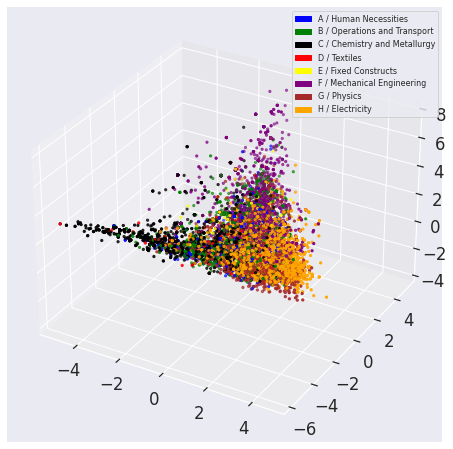

In [56]:
#this plot was created to be opened in jupyter notebook (to have an interactive 3D Chart and being able to see the clusters better)
#%matplotlib notebook #activate this in jupyter
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection = '3d')


x = X_r2[:,0]
y = X_r2[:,1]
z = X_r2[:,2]

ax.scatter(x,y,z, c = df["colours"], marker = ".")

col_a = mpatches.Patch(color='blue', label='A / Human Necessities')
col_b = mpatches.Patch(color='green', label='B / Operations and Transport')
col_c = mpatches.Patch(color='black', label='C / Chemistry and Metallurgy')
col_d = mpatches.Patch(color='red', label='D / Textiles')
col_e = mpatches.Patch(color='yellow', label='E / Fixed Constructs')
col_f = mpatches.Patch(color='purple', label='F / Mechanical Engineering')
col_g = mpatches.Patch(color='brown', label='G / Physics')
col_h = mpatches.Patch(color='orange', label='H / Electricity')
handles=[col_a, col_b, col_c, col_d, col_e, col_f, col_g, col_h]
plt.legend(handles=handles, loc = "upper right", fontsize = 8);

#we would expect B, E, F, G and H to be close to another! (green, yellow, purple, brown, orange); just by topic names
#others: black, blue, red
#However, we can see that only black is clustered apart (and still some outliers fall into other clusters)
#interestingly, purple seems somewhat separated as well.

## Summarizing EDA & Preprocessing:
 - Some anchors are shared among several contexts (and general categories
 - Most context contain several different anchors
 - Some contexts are heavily outweighing others in overall occurence (heavily right-skewed)
 - In general, the contexts of the categories D & E are under-represented in the data
 - The proportion of scores are more or less similar around all contexts
 - Most of the contexts in which we want to predict the scores are similar in regards to words used and words lengths
 
 
 - It does not make sense to remove stop words or short words, since they actually impact the score ("accept information -> accept this information" = 0.75)
 - Abbreviations are a thing in the dataset (e.g., Electromagnetic = em; Water = h2o) -> It might makes sense to find a model for domain specific abbreviations (also for possibly unknown categories & abbreviations in the test set)
     -> BUT: abreviations also penalize score!
 - Synonyms are often not as heavily penalized as abreviations - a good synonym finder will be helpful
     -> generally, the penalization of synonyms seems to be sometimes weird (e.g., absorbant properties and absorbant characteristics is a perfect match at one point (id: 621b048d70aa8867) but absorption characteristics an inperfect match (0.75) at another point (id: e6f92889099fd908)) -> maybe lemmatization will mess up these relationships were they are considered "inperfect" because there are two small misallignments
 - Train Data is relatively small (given we also want validation), so we will need a pre-trained model (although it would be nice to train it ourselves, given we are acting in domain specific environments)

# Modeling

TODO:
Next steps:
- similarities (maybe wordnet; maybe more domain specific?, gotta read into it)
- abbreviations 
- generally, find pretrained model
- just for fun: maybe score can be easily algorithmed (e.g., abbreviation = -0.25; using very similar word instead = -0; using two very similar words instead = -0.25; etc.; if target is way shorter than anchor = -0.25 etc.)